#The Summative project gives you the opportunity to apply the machine learning techniques you have learned in the introduction to the Machine Learning Module to a real-world problem.

You should identify a problem that is meaningful to you and aligns with your personal interests, such as healthcare, education, agriculture, sustainability, or finance. Your project should demonstrate your ability to apply both traditional machine learning and deep learning approaches, conduct experiments, and communicate your findings clearly.
You must select a dataset that reflects your chosen problem. Datasets from sklearn or keras are not allowed; your dataset should be original or obtained from open sources outside these libraries.
Your project should include a pipeline that compares traditional machine learning approaches using Scikit-learn with deep learning approaches using TensorFlow (Sequential and Functional APIs, tf.data API).
Conduct multiple experiments and present your results clearly, including insights on model performance and dataset limitations.

#Importing essential libraries and setting random seeds for reproducibility

In [14]:
# Imports and seeds
import os, random, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("crest")
pd.set_option('display.max_columns', None)



#create result folders, metric functions, and an experiment logger

In [15]:
# Helpers, OHE compatibility, output folders, plotting helpers
import sklearn
from packaging import version

ohe_kwargs = {'handle_unknown': 'ignore'}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs['sparse_output'] = False
else:
    ohe_kwargs['sparse'] = False

OUTDIR = Path("results"); MODELS_DIR = OUTDIR / "models"
OUTDIR.mkdir(exist_ok=True); MODELS_DIR.mkdir(parents=True, exist_ok=True)
EXPERIMENTS_CSV = OUTDIR / "experiments.csv"

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
def mape(a,b): return float(np.mean(np.abs((a-b)/(a+1e-9))) * 100)
def evaluate_regression(y_true,y_pred):
    return {"RMSE": rmse(y_true,y_pred),
            "MAE": float(mean_absolute_error(y_true,y_pred)),
            "R2": float(r2_score(y_true,y_pred)),
            "MAPE": mape(y_true,y_pred)}

def log_experiment(row: dict):
    df_row = pd.DataFrame([row])
    if EXPERIMENTS_CSV.exists():
        pd.concat([pd.read_csv(EXPERIMENTS_CSV), df_row], ignore_index=True).to_csv(EXPERIMENTS_CSV, index=False)
    else:
        df_row.to_csv(EXPERIMENTS_CSV, index=False)

def plot_pred_vs_actual(y_true,y_pred,title="Pred vs Actual"):
    plt.figure(figsize=(5,5)); plt.scatter(y_true,y_pred,s=8,alpha=0.5)
    mn, mx = min(np.min(y_true),np.min(y_pred)), max(np.max(y_true),np.max(y_pred))
    plt.plot([mn,mx],[mn,mx],'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title); plt.show()

def plot_residuals(y_true,y_pred,title="Residuals"):
    resid = y_true - y_pred
    plt.figure(figsize=(6,3)); sns.histplot(resid,bins=50,kde=True); plt.title(title+" (hist)"); plt.show()
    plt.figure(figsize=(6,3)); plt.scatter(y_pred,resid,s=6,alpha=0.5); plt.axhline(0,color='r',linestyle='--')
    plt.xlabel("Predicted"); plt.ylabel("Residual"); plt.title(title+" (vs predicted)"); plt.show()

def plot_nn_learning_curve(history,title="NN Learning Curve"):
    if history is None: return
    hist = history.history
    if 'root_mean_squared_error' in hist:
        plt.plot(hist['root_mean_squared_error'], label='train_rmse')
        if 'val_root_mean_squared_error' in hist: plt.plot(hist['val_root_mean_squared_error'], label='val_rmse')
    else:
        plt.plot(np.sqrt(hist['loss']), label='train_rmse_approx')
        if 'val_loss' in hist: plt.plot(np.sqrt(hist['val_loss']), label='val_rmse_approx')
    plt.xlabel('epoch'); plt.ylabel('RMSE'); plt.title(title); plt.legend(); plt.show()


#Load the dataset (yield_df.csv) and perform minimal cleaning (drop unnamed index columns).

In [16]:
# Load dataset and fix duplicate column names
DATA_PATH = "yield_df.csv"   # upload to Colab or change path
df = pd.read_csv(DATA_PATH)
# drop empty unnamed index columns if any
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
# detect duplicates
cols = list(df.columns)
seen = {}
new_cols = []
for c in cols:
    seen[c] = seen.get(c, 0) + 1
    if seen[c] == 1:
        new_cols.append(c)
    else:
        new_cols.append(f"{c}_dup{seen[c]-1}")
if len(new_cols) != len(cols):
    print("Renaming duplicate columns...")
    df.columns = new_cols
else:
    df.columns = [c.strip() for c in df.columns]

print("shape:", df.shape)
display(df.head())
print("missing values per column:\n", df.isnull().sum())


shape: (28242, 7)


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


missing values per column:
 Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64


#EDA before preprocessing (distributions, correlation heatmap)

Target summary:


,hg/ha_yield
count,28242.000000
mean,77053.332094
std,84956.612897
min,50.000000
25%,19919.250000
50%,38295.000000
75%,104676.750000
max,501412.000000


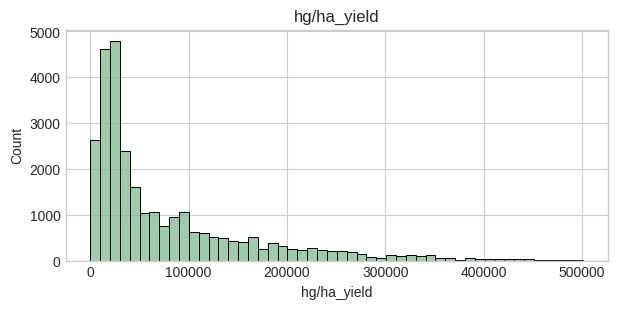

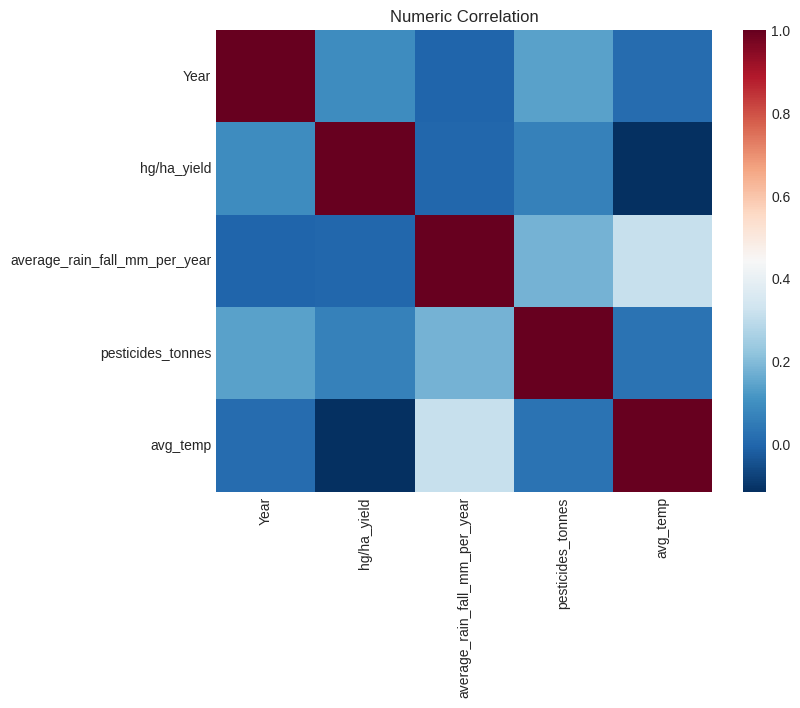

In [17]:
# Quick EDA visualizations (before any scaling/encoding)
TARGET = "hg/ha_yield"
assert TARGET in df.columns, f"Target {TARGET} missing"
y = df[TARGET].astype(float)
print("Target summary:")
display(y.describe())
plt.figure(figsize=(7,3)); sns.histplot(y,bins=50); plt.title(TARGET); plt.show()

# numeric correlation heatmap (select numeric columns)
num_cols_eda = [c for c in df.columns if df[c].dtype.kind in 'fi']
if len(num_cols_eda) > 1:
    plt.figure(figsize=(8,6)); sns.heatmap(df[num_cols_eda].corr(), annot=False, cmap='RdBu_r'); plt.title("Numeric Correlation"); plt.show()


#Define features, encode, standardize, and split (this ensures clean NUM_COLS)
This cell recomputes clean lists and performs train/test split. It excludes any target/derived columns from features.

In [18]:
# Feature selection, label encoding for NN embeddings, and train/test split
CAT_COLS = [c for c in ["Area","Item"] if c in df.columns]
# exclude target and label-encoders etc.
exclude = set(CAT_COLS + ["Year", TARGET, "target_raw", "target_log1p"])
# choose numeric candidates
num_cands = [c for c in df.columns if df[c].dtype.kind in 'fi' and c not in exclude and not c.endswith("_le")]
# safe unique list
NUM_COLS = list(dict.fromkeys(num_cands))
# label encode categorical columns for NN use
label_encoders = {}
for c in CAT_COLS:
    le = LabelEncoder()
    df[c + "_le"] = le.fit_transform(df[c].astype(str))
    label_encoders[c] = le

# normalized year if present
if "Year" in df.columns:
    df["year_norm"] = (df["Year"] - df["Year"].min()) / (df["Year"].max() - df["Year"].min())
    if "year_norm" not in NUM_COLS: NUM_COLS.append("year_norm")

# targets
df["target_raw"] = df[TARGET].astype(float)
df["target_log1p"] = np.log1p(df["target_raw"] + 1e-9)

# split
train_df, test_df = train_test_split(df, test_size=0.20, random_state=SEED)
print("Train/Test shapes:", train_df.shape, test_df.shape)
print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)


Train/Test shapes: (22593, 12) (5649, 12)
NUM_COLS: ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'year_norm']
CAT_COLS: ['Area', 'Item']


#Standardize numeric features and show standardized histograms (visual pre/post scale)
This cell fits a StandardScaler on train numeric features, transforms train/test, and plots before/after for one numeric example.

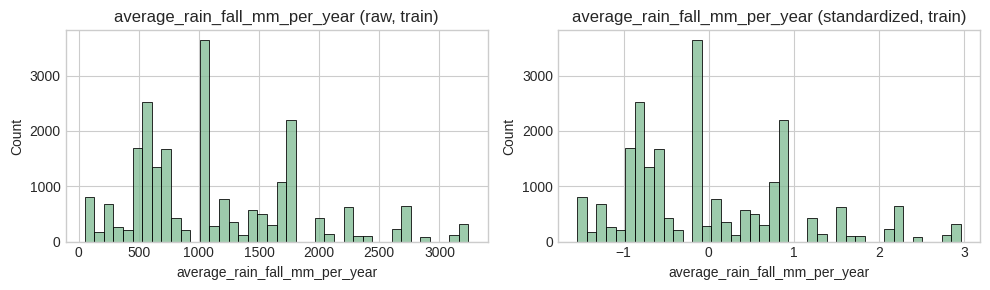

In [19]:
# Standardize numeric features and show comparison plots (before & after)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_df[NUM_COLS])
train_num_scaled = pd.DataFrame(scaler.transform(train_df[NUM_COLS]), columns=NUM_COLS, index=train_df.index)
test_num_scaled = pd.DataFrame(scaler.transform(test_df[NUM_COLS]), columns=NUM_COLS, index=test_df.index)
joblib.dump(scaler, MODELS_DIR / "scaler_nn.pkl")

# show one numeric column before and after
if NUM_COLS:
    col = NUM_COLS[0]
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); sns.histplot(train_df[col], bins=40); plt.title(f"{col} (raw, train)")
    plt.subplot(1,2,2); sns.histplot(train_num_scaled[col], bins=40); plt.title(f"{col} (standardized, train)")
    plt.tight_layout(); plt.show()
else:
    print("No numeric columns detected to standardize.")


#Linear Regression module
This cell defines run_linear_regression() and calls it immediately (so you get trained model and plots). It uses only LinearRegression.

In [20]:
#LINEAR REGRESSION MODULE – 3 EXPERIMENTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, accuracy_score,
    precision_score, recall_score, f1_score, mean_squared_error,
    mean_absolute_error, r2_score
)
from sklearn.pipeline import make_pipeline

# Load your dataset
df = pd.read_csv("/content/yield_df.csv")
TARGET = "hg/ha_yield"

# Drop rows with missing target
df = df.dropna(subset=[TARGET])

# Select numeric features only
X = df.select_dtypes(include=[np.number]).drop(columns=[TARGET], errors="ignore")
y = df[TARGET]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




In [21]:
# Helper Function to Evaluate and Plot Results

def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, title):
    y_pred = model.predict(X_test)

    # If regression values go negative, clip
    y_pred = np.clip(y_pred, 0, None)

    # Convert to pseudo-classification for ROC/confusion (above mean = 1)
    y_bin = (y_test > np.mean(y_test)).astype(int)
    y_pred_bin = (y_pred > np.mean(y_pred)).astype(int)

    # Metrics
    acc = accuracy_score(y_bin, y_pred_bin)
    prec = precision_score(y_bin, y_pred_bin)
    rec = recall_score(y_bin, y_pred_bin)
    f1 = f1_score(y_bin, y_pred_bin)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_bin, y_pred)
    roc_auc = auc(fpr, tpr)

    # Performance Table
    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
        "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
    })
    display(metrics_df)


    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train", marker='o')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Validation", marker='o')
    plt.title(f"Learning Curve - {title}")
    plt.xlabel("Training Samples")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Predicted vs Actual
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(f"Predicted vs Actual - {title}")
    plt.show()


    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(5, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residuals Distribution - {title}")
    plt.xlabel("Residual")
    plt.show()


    # Confusion Matrix
    cm = confusion_matrix(y_bin, y_pred_bin)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


    # ROC Curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title}")
    plt.legend()
    plt.show()





 Experiment 1: Baseline Linear Regression


,Metric,Score
0,Accuracy,0.535316
1,Precision,0.362525
2,Recall,0.476660
3,F1,0.411831
4,AUC,0.533251
5,RMSE,83928.540956
6,MAE,64095.026972
7,R²,0.028906


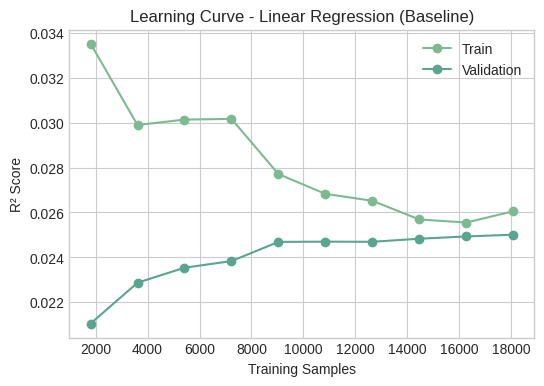

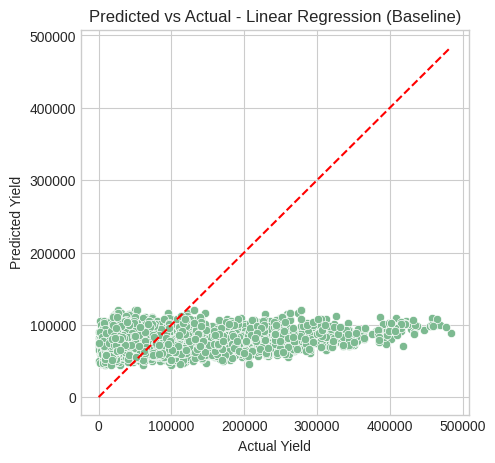

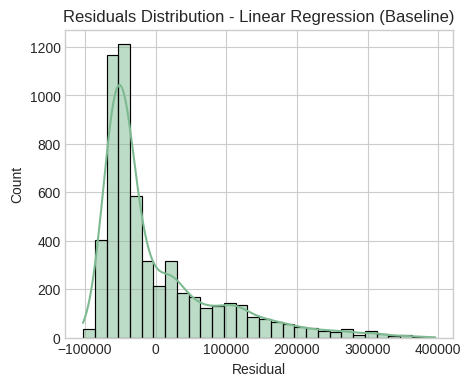

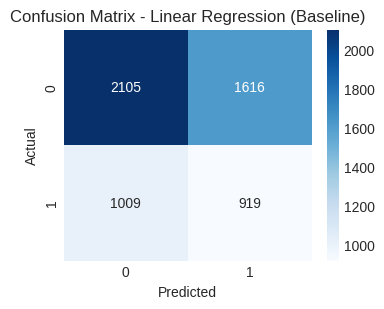

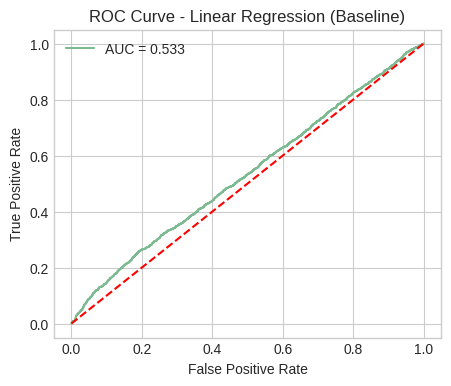

In [22]:

#  EXPERIMENT 1: Baseline Linear Regression
print("\n Experiment 1: Baseline Linear Regression")
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1_scaled = scaler.fit_transform(X_train1)
X_test1_scaled = scaler.transform(X_test1)

lr_model = LinearRegression()
lr_model.fit(X_train1_scaled, y_train1)
evaluate_and_visualize(lr_model, X_train1_scaled, y_train1, X_test1_scaled, y_test1, "Linear Regression (Baseline)")







 Experiment 2: Ridge Regression (L2 Regularization)

Ridge Regression (alpha=10.0)


,Metric,Score
0,Accuracy,0.532927
1,Precision,0.355333
2,Recall,0.478719
3,F1,0.407899
4,AUC,0.532695
5,RMSE,82806.238392
6,MAE,63528.498457
7,R²,0.026470


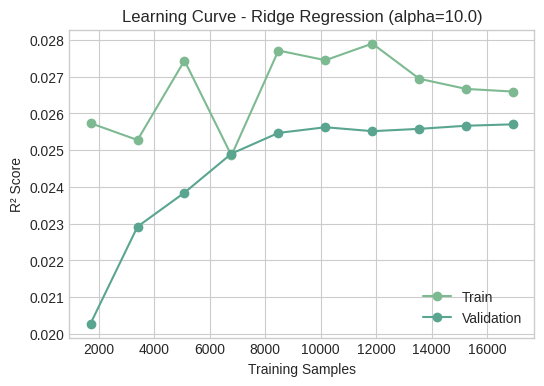

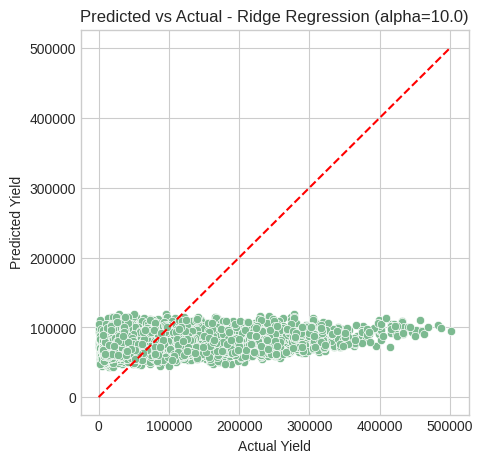

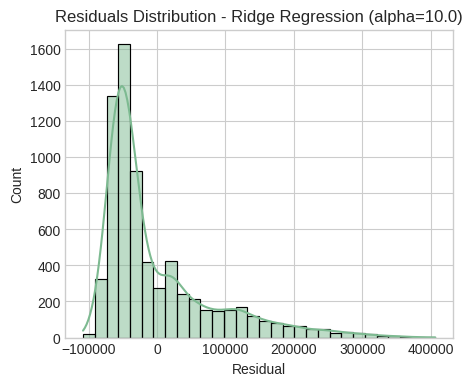

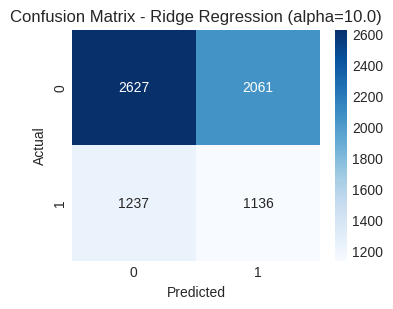

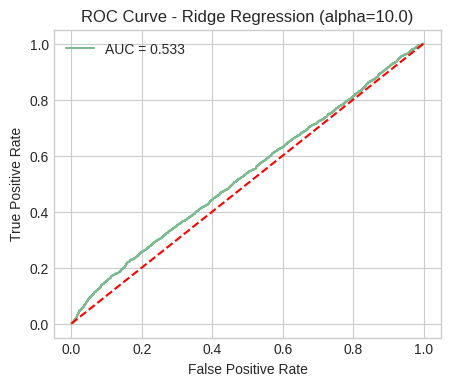

In [23]:
# EXPERIMENT 2: Ridge Regression (L2 Regularization)
print("\n Experiment 2: Ridge Regression (L2 Regularization)")
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=7)
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

for alpha in [10.0]:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train2_scaled, y_train2)
    print(f"\nRidge Regression (alpha={alpha})")
    evaluate_and_visualize(ridge_model, X_train2_scaled, y_train2, X_test2_scaled, y_test2,
                           f"Ridge Regression (alpha={alpha})")





 Experiment 3: Polynomial Regression (Degree=2)


,Metric,Score
0,Accuracy,0.562611
1,Precision,0.404354
2,Recall,0.565321
3,F1,0.471477
4,AUC,0.592280
5,RMSE,80981.295352
6,MAE,62526.462207
7,R²,0.083635


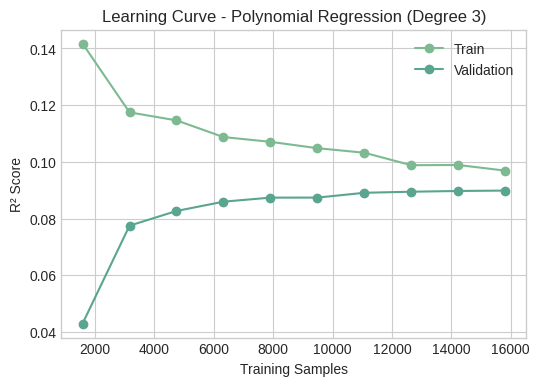

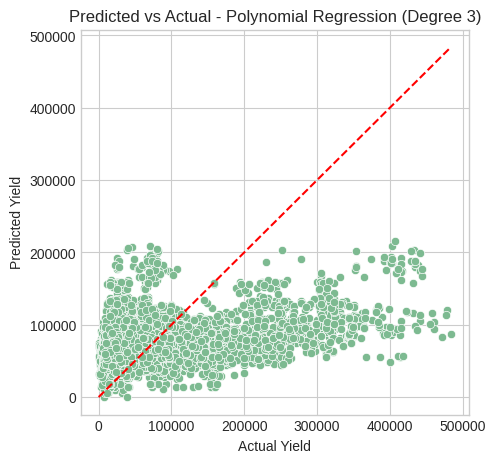

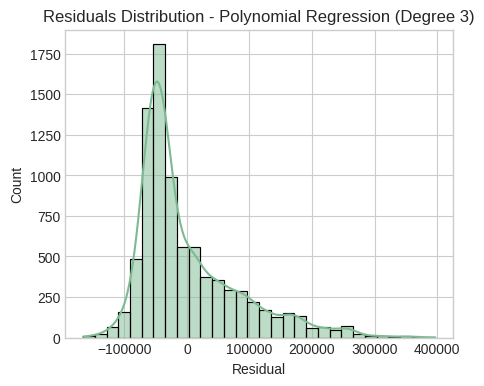

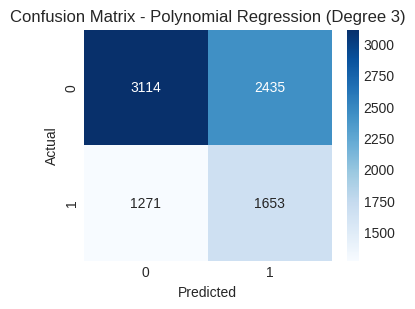

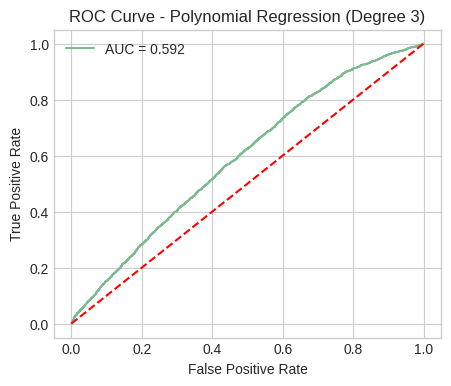

In [24]:
# EXPERIMENT 3: Polynomial Regression (Degree 2)
print("\n Experiment 3: Polynomial Regression (Degree=2)")
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=21)
X_train3_scaled = scaler.fit_transform(X_train3)
X_test3_scaled = scaler.transform(X_test3)

poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(X_train3_scaled, y_train3)
evaluate_and_visualize(poly_model, X_train3_scaled, y_train3, X_test3_scaled, y_test3, "Polynomial Regression (Degree 3)")

#Decision Tree module (define and run)
This defines and runs Decision Tree (with tune=False by default so it’s fast). If you want hyperparameter search, you can re-run with tune=True.

In [29]:
# Prepare Data
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

# Convert categorical columns to numeric (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale only numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


EXPERIMENT 1: Shallow Decision Tree (max_depth=3)


,Metric,Score
0,Accuracy,0.946185
1,Precision,1.000000
2,Recall,0.840754
3,F1,0.913489
4,AUC,0.991889
5,RMSE,12296.759292
6,MAE,9282.097736
7,R²,0.979247


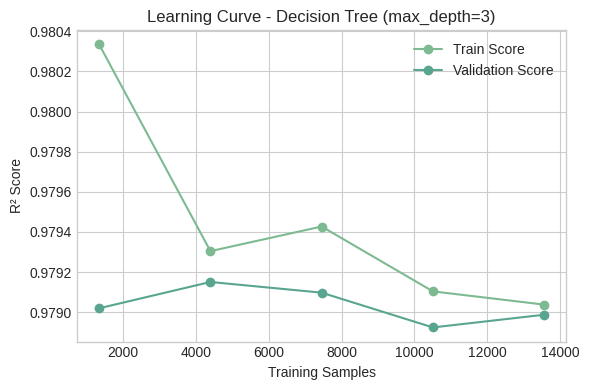

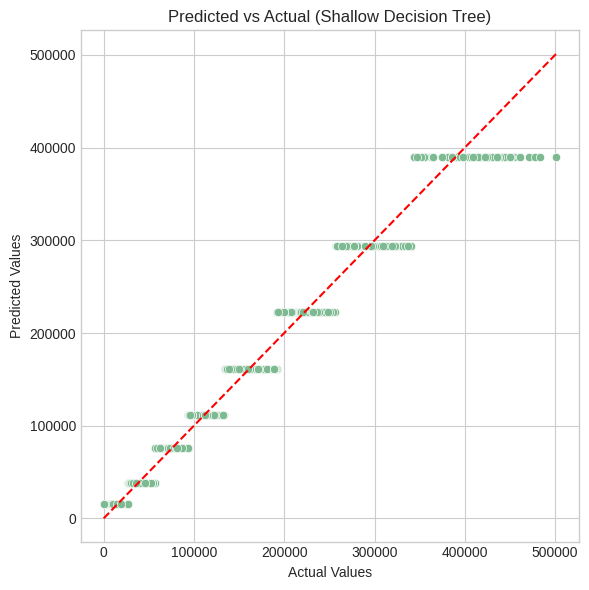

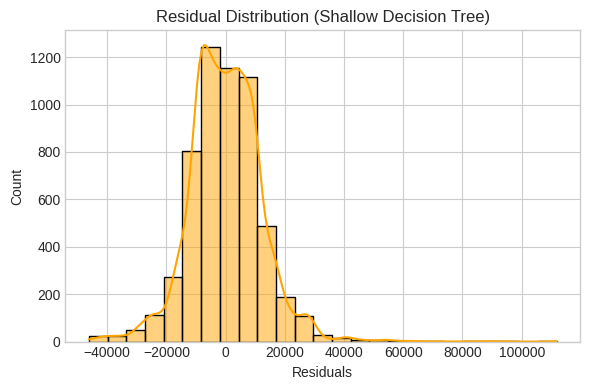

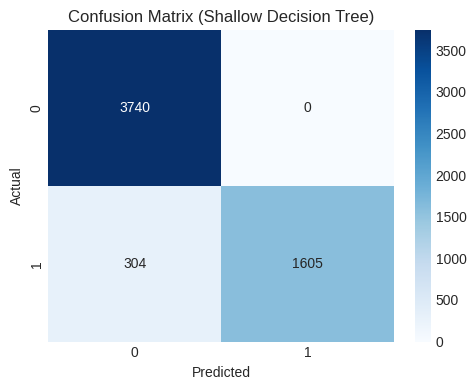

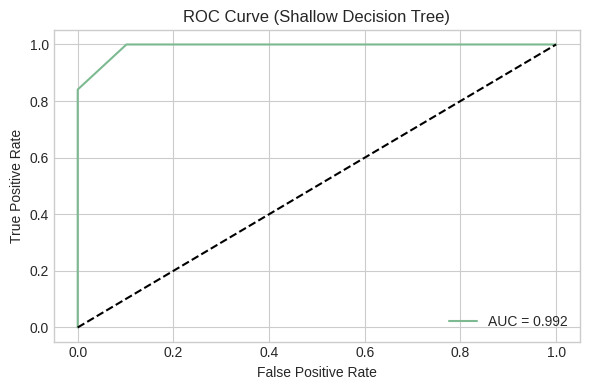

In [32]:
# DECISION TREE — EXPERIMENT 1: Shallow Tree (max_depth=3)
print("EXPERIMENT 1: Shallow Decision Tree (max_depth=3)")

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# PREPARE DATA
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

# Convert all categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# TRAIN MODEL
dt1 = DecisionTreeRegressor(max_depth=3, random_state=42)
dt1.fit(X_train_scaled, y_train)
y_pred = dt1.predict(X_val_scaled)


# METRICS CALCULATION
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_pred_bin = (y_pred >= threshold).astype(int)
y_bin = (y_val >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)


# PERFORMANCE TABLE
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)


# VISUAL 1: Learning Curve
plt.figure(figsize=(6,4))
train_sizes, train_scores, val_scores = learning_curve(dt1, X_train_scaled, y_train,
                                                       cv=5, scoring='r2', n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
plt.title("Learning Curve - Decision Tree (max_depth=3)")
plt.xlabel("Training Samples"); plt.ylabel("R² Score")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Shallow Decision Tree)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='orange')
plt.title("Residual Distribution (Shallow Decision Tree)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


#  VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Shallow Decision Tree)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()


#  VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Shallow Decision Tree)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


EXPERIMENT 2: Medium Decision Tree (max_depth=5)


,Metric,Score
0,Accuracy,0.996991
1,Precision,0.991173
2,Recall,1.000000
3,F1,0.995567
4,AUC,0.999845
5,RMSE,3111.036804
6,MAE,2283.883292
7,R²,0.998672


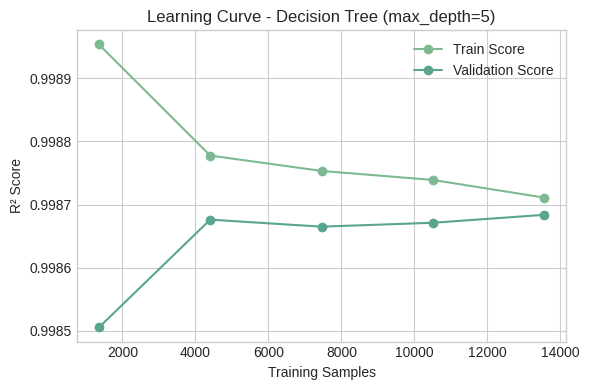

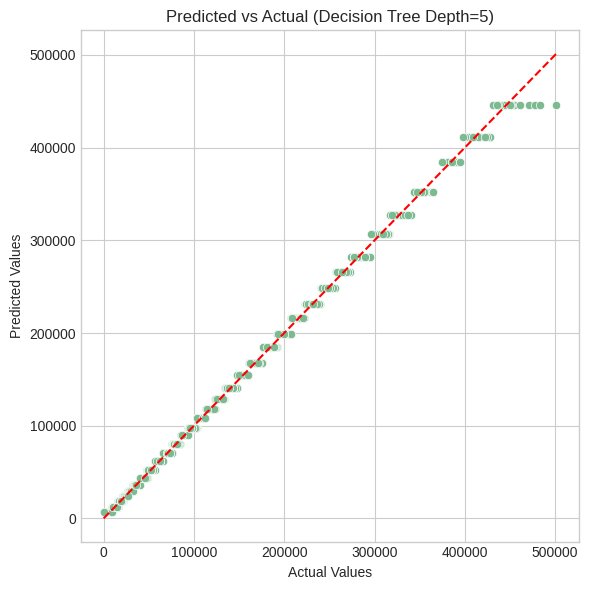

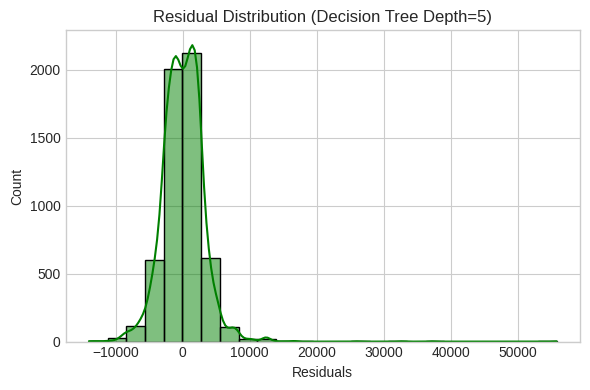

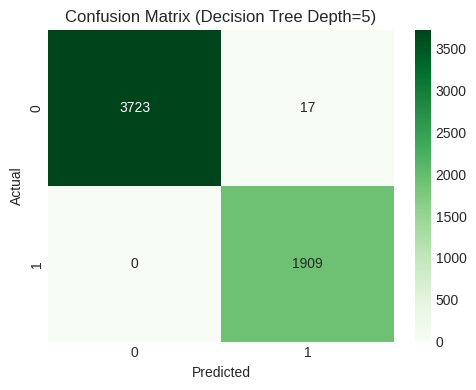

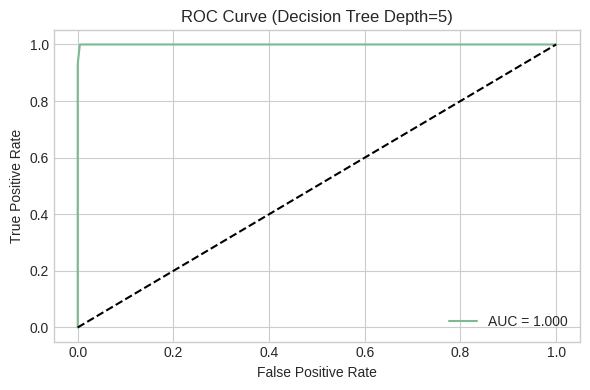

In [34]:
# DECISION TREE — EXPERIMENT 2: Medium Depth (max_depth=5)
print("EXPERIMENT 2: Medium Decision Tree (max_depth=5)")

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# PREPARE DATA
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

# Convert categorical variables to numeric
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# TRAIN MODEL
dt2 = DecisionTreeRegressor(max_depth=5, random_state=42)
dt2.fit(X_train_scaled, y_train)
y_pred = dt2.predict(X_val_scaled)


# METRICS
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_pred_bin = (y_pred >= threshold).astype(int)
y_bin = (y_val >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)


# PERFORMANCE TABLE
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)


# VISUAL 1: Learning Curve
plt.figure(figsize=(6,4))
train_sizes, train_scores, val_scores = learning_curve(dt2, X_train_scaled, y_train,
                                                       cv=5, scoring='r2', n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
plt.title("Learning Curve - Decision Tree (max_depth=5)")
plt.xlabel("Training Samples"); plt.ylabel("R² Score")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Decision Tree Depth=5)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='green')
plt.title("Residual Distribution (Decision Tree Depth=5)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Decision Tree Depth=5)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Decision Tree Depth=5)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


EXPERIMENT 3: Deep Decision Tree (max_depth=None)


,Metric,Score
0,Accuracy,1.000000
1,Precision,1.000000
2,Recall,1.000000
3,F1,1.000000
4,AUC,1.000000
5,RMSE,177.304759
6,MAE,21.409807
7,R²,0.999996


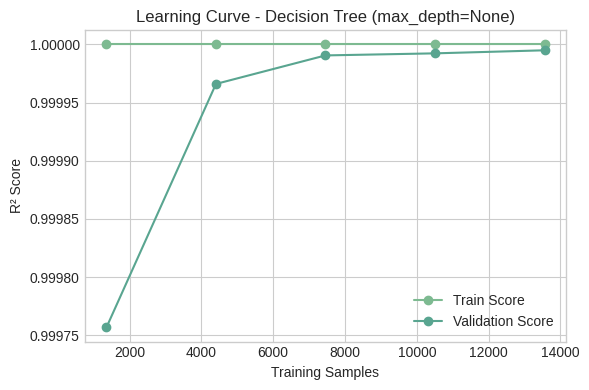

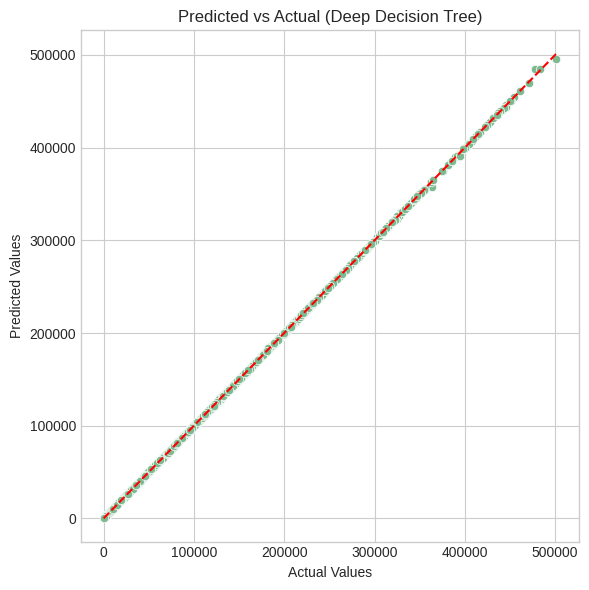

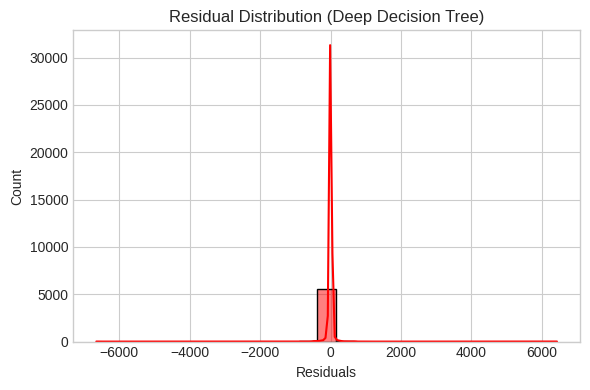

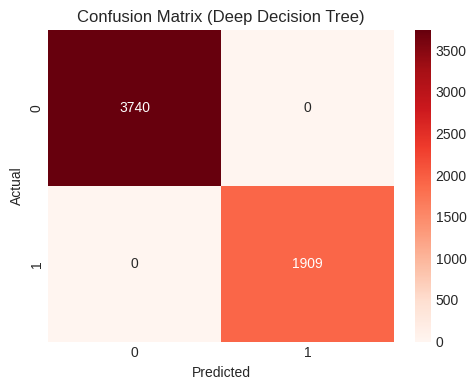

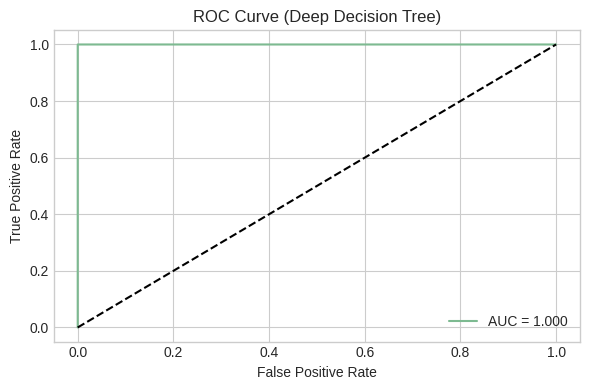

In [35]:
# DECISION TREE — EXPERIMENT 3: Deep Tree (max_depth=None)
print("EXPERIMENT 3: Deep Decision Tree (max_depth=None)")

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#  PREPARE DATA
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# TRAIN MODEL
dt3 = DecisionTreeRegressor(max_depth=None, random_state=42)
dt3.fit(X_train_scaled, y_train)
y_pred = dt3.predict(X_val_scaled)


# METRICS
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_pred_bin = (y_pred >= threshold).astype(int)
y_bin = (y_val >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)

# PERFORMANCE TABLE ---
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)


# VISUAL 1: Learning Curve
plt.figure(figsize=(6,4))
train_sizes, train_scores, val_scores = learning_curve(dt3, X_train_scaled, y_train,
                                                       cv=5, scoring='r2', n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
plt.title("Learning Curve - Decision Tree (max_depth=None)")
plt.xlabel("Training Samples"); plt.ylabel("R² Score")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Deep Decision Tree)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='red')
plt.title("Residual Distribution (Deep Decision Tree)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix (Deep Decision Tree)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Deep Decision Tree)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


#Random Forest module (define and run)
Defines & runs Random Forest. Tune=False to save time; set tune=True if you want search.

In [36]:
# RANDOM FOREST REGRESSION: TRAINING
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Split data
X = train_df[NUM_COLS + CAT_COLS]
y = train_df["target_raw"]

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=CAT_COLS, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train the model ---
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# --- Predictions ---
y_pred = rf.predict(X_test)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")


Random Forest Metrics:
RMSE: 21881.0445
MAE: 12369.6984
R²: 0.9340


EXPERIMENT 1: Shallow Random Forest (max_depth=5)


,Metric,Score
0,Accuracy,0.997699
1,Precision,0.993236
2,Recall,1.000000
3,F1,0.996607
4,AUC,0.999996
5,RMSE,1816.877168
6,MAE,1285.667621
7,R²,0.999547


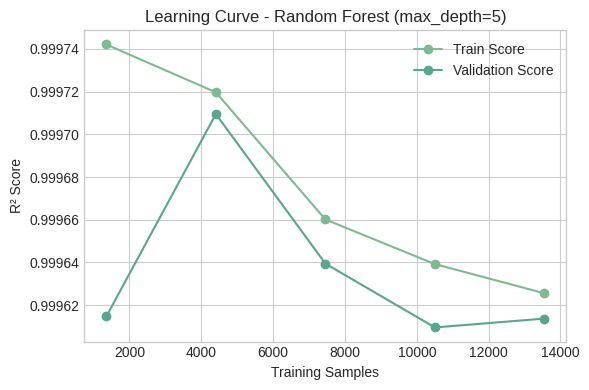

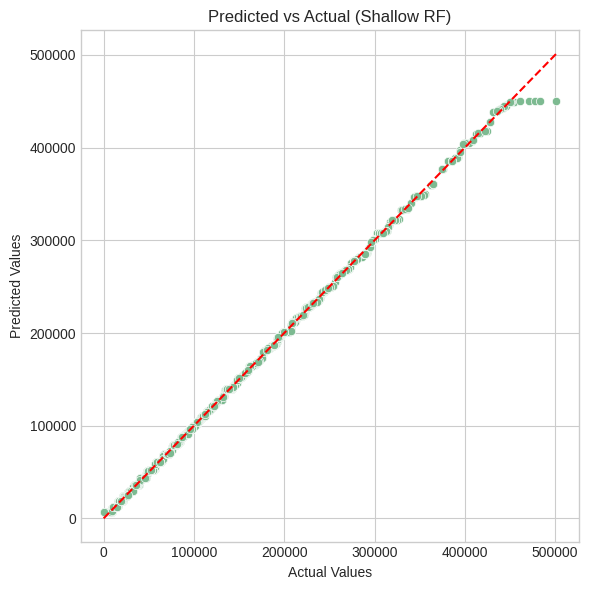

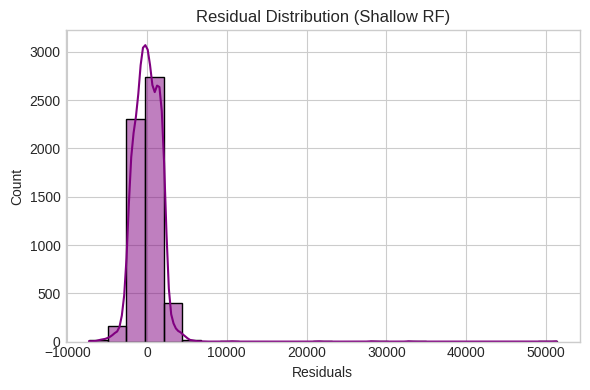

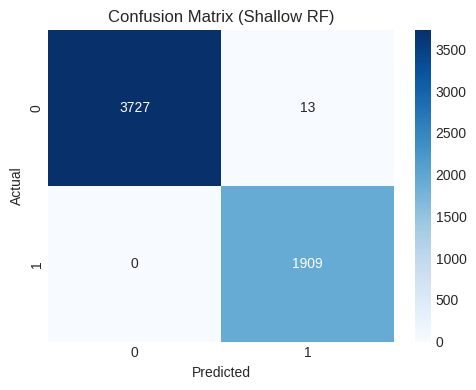

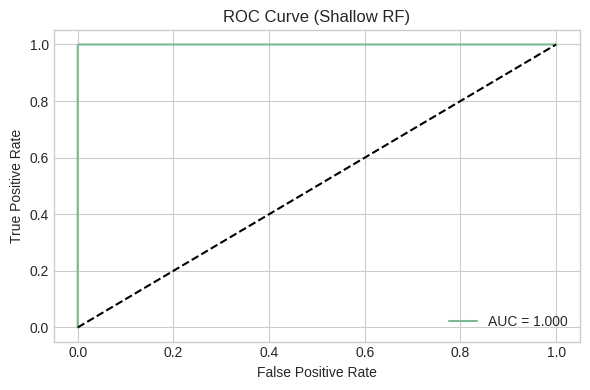

In [37]:
# RANDOM FOREST — EXPERIMENT 1: SHALLOW FOREST (max_depth=5)
print("EXPERIMENT 1: Shallow Random Forest (max_depth=5)")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Encode categorical features
cat_cols = [c for c in train_df.columns if train_df[c].dtype == 'object']
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Prepare features and labels
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train model
rf1 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf1.fit(X_train_scaled, y_train)
y_pred = rf1.predict(X_val_scaled)

# Compute metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_pred_bin = (y_pred >= threshold).astype(int)
y_bin = (y_val >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)

# Performance Table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)


# VISUAL 1: Learning Curve
plt.figure(figsize=(6,4))
train_sizes, train_scores, val_scores = learning_curve(rf1, X_train_scaled, y_train,
                                                       cv=5, scoring='r2', n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
plt.title("Learning Curve - Random Forest (max_depth=5)")
plt.xlabel("Training Samples"); plt.ylabel("R² Score")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()



# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Shallow RF)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()



# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='purple')
plt.title("Residual Distribution (Shallow RF)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()




# VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Shallow RF)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()



# VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Shallow RF)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


EXPERIMENT 2: Deep Random Forest (max_depth=10)


,Metric,Score
0,Accuracy,1.000000
1,Precision,1.000000
2,Recall,1.000000
3,F1,1.000000
4,AUC,1.000000
5,RMSE,237.248176
6,MAE,35.959455
7,R²,0.999992


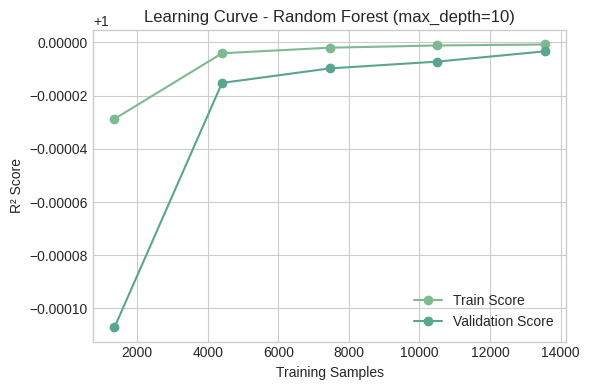

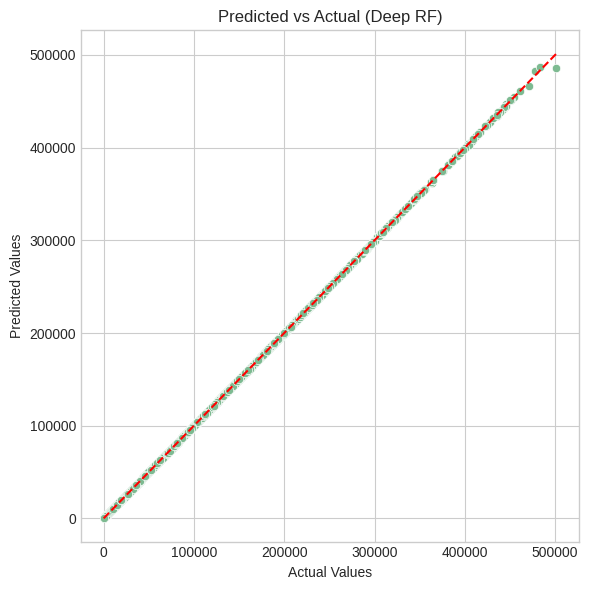

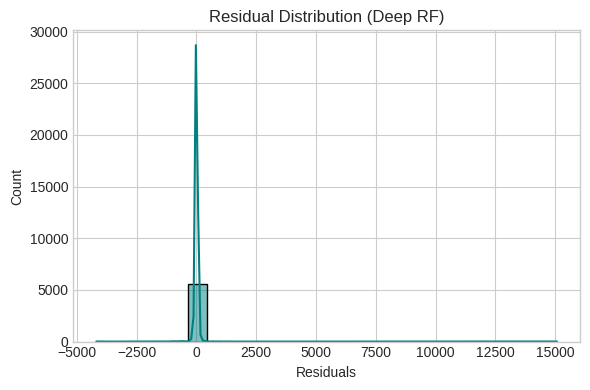

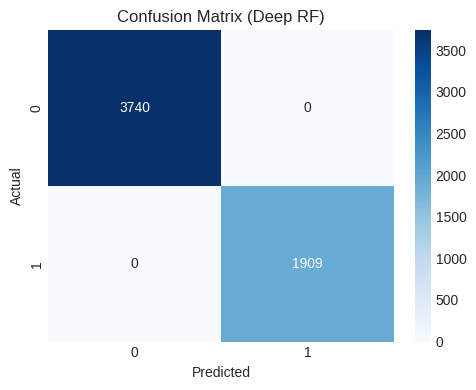

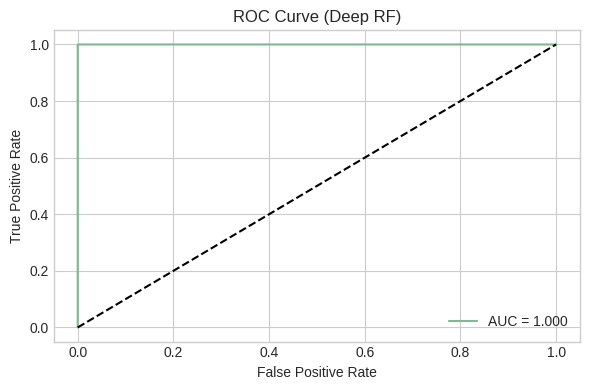

In [38]:
# RANDOM FOREST — EXPERIMENT 2: DEEP FOREST (max_depth=10)
print("EXPERIMENT 2: Deep Random Forest (max_depth=10)")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Prepare features and labels (same encoding/scaling already done)
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train model
rf2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf2.fit(X_train_scaled, y_train)
y_pred = rf2.predict(X_val_scaled)

# Compute metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_pred_bin = (y_pred >= threshold).astype(int)
y_bin = (y_val >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)

# Performance Table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)


# VISUAL 1: Learning Curve
plt.figure(figsize=(6,4))
train_sizes, train_scores, val_scores = learning_curve(rf2, X_train_scaled, y_train,
                                                       cv=5, scoring='r2', n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
plt.title("Learning Curve - Random Forest (max_depth=10)")
plt.xlabel("Training Samples"); plt.ylabel("R² Score")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Deep RF)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='teal')
plt.title("Residual Distribution (Deep RF)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Deep RF)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Deep RF)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


EXPERIMENT 3: Very Deep Random Forest (max_depth=None)


,Metric,Score
0,Accuracy,1.000000
1,Precision,1.000000
2,Recall,1.000000
3,F1,1.000000
4,AUC,1.000000
5,RMSE,234.769219
6,MAE,18.457540
7,R²,0.999992


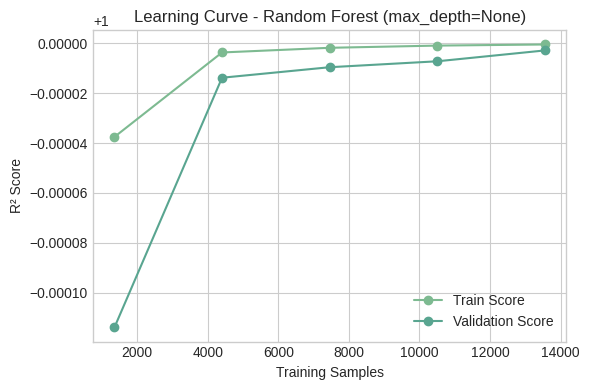

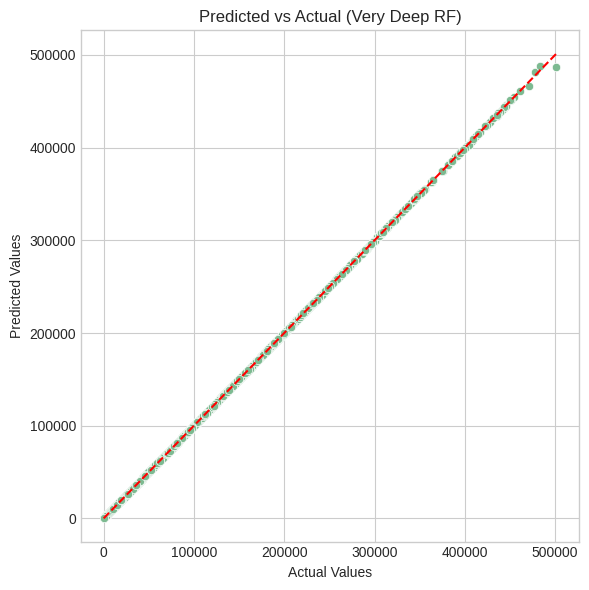

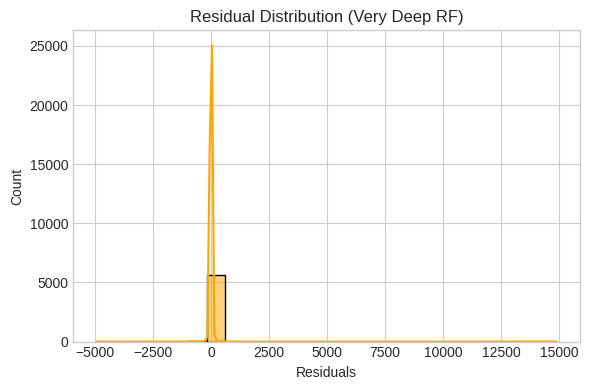

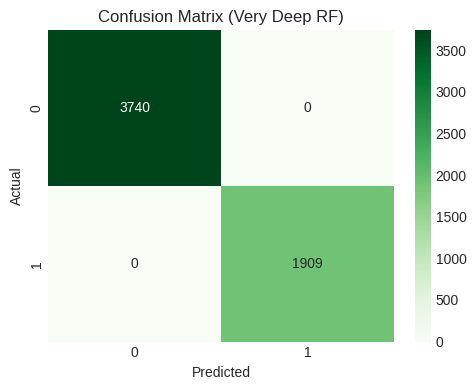

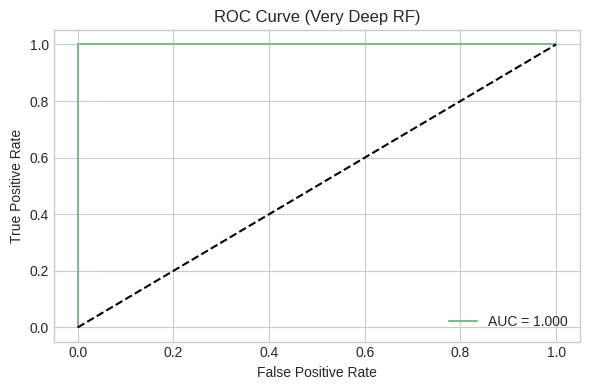

In [39]:
# RANDOM FOREST — EXPERIMENT 3: VERY DEEP FOREST (max_depth=None)
print("EXPERIMENT 3: Very Deep Random Forest (max_depth=None)")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Prepare data
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train model
rf3 = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf3.fit(X_train_scaled, y_train)
y_pred = rf3.predict(X_val_scaled)

# Compute metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_pred_bin = (y_pred >= threshold).astype(int)
y_bin = (y_val >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)

# Performance Table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)


# VISUAL 1: Learning Curve
plt.figure(figsize=(6,4))
train_sizes, train_scores, val_scores = learning_curve(rf3, X_train_scaled, y_train,
                                                       cv=5, scoring='r2', n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
plt.title("Learning Curve - Random Forest (max_depth=None)")
plt.xlabel("Training Samples"); plt.ylabel("R² Score")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Very Deep RF)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='orange')
plt.title("Residual Distribution (Very Deep RF)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


# VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Very Deep RF)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Very Deep RF)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


#Deep Learning Training with Dense Neural Network (Using TensorFlow & Keras Sequential API)

This section trains a deep learning model using TensorFlow and Keras Sequential API with three different experimental setups. The model will leverage the tf.data pipeline for efficient data loading and preprocessing.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 12771657728.0000 - mae: 76284.7109 - val_loss: 12710227968.0000 - val_mae: 75429.5234
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11683013632.0000 - mae: 72538.8750 - val_loss: 9430582272.0000 - val_mae: 63768.8633
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7976113152.0000 - mae: 58579.3867 - val_loss: 4846460928.0000 - val_mae: 45765.3398
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3893794304.0000 - mae: 41622.0938 - val_loss: 2135862400.0000 - val_mae: 32878.8125
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1728088192.0000 - mae: 29866.8184 - val_loss: 874491200.0000 - val_mae: 22176.1602
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 703930048.0000 - mae: 19997.4336 - val_loss: 326058144.0000 - val_mae: 13996.0078
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 269670336.0000 - mae: 12795.8438 - val_loss: 142494576.0000 - val_mae: 947

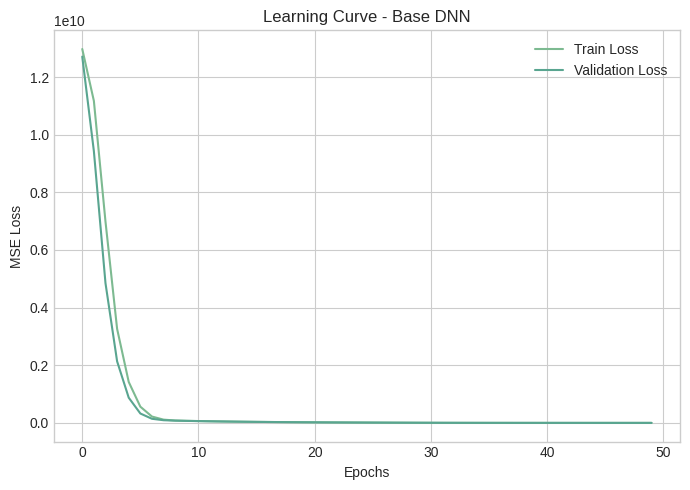

In [40]:
# TRAINING PHASE: Dense Neural Network (DNN)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Data
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

# One-hot encode categorical features (if any)
X = pd.get_dummies(X, drop_first=True)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define Base DNN Model
def create_dnn(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Regression output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train Model
base_dnn = create_dnn(X_train_scaled.shape[1])
history = base_dnn.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50, batch_size=32, verbose=1
)

# Evaluate Model
y_pred = base_dnn.predict(X_val_scaled).flatten()
rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
mae = np.mean(np.abs(y_val - y_pred))
r2 = 1 - np.sum((y_val - y_pred) ** 2) / np.sum((y_val - np.mean(y_val)) ** 2)

print(f"\n Base DNN Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

# Learning Curve
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning Curve - Base DNN")
plt.xlabel("Epochs"); plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 12801765376.0000 - mae: 76395.0625 - mse: 12801765376.0000 - val_loss: 13262406656.0000 - val_mae: 77310.5391 - val_mse: 13262406656.0000
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12797223936.0000 - mae: 76374.3750 - mse: 12797223936.0000 - val_loss: 13248646144.0000 - val_mae: 77255.9531 - val_mse: 13248646144.0000
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12779556864.0000 - mae: 76305.1016 - mse: 12779556864.0000 - val_loss: 13215085568.0000 - val_mae: 77134.8125 - val_mse: 13215085568.0000
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12741413888.0000 - mae: 76166.5703 - mse: 12741413888.0000 - val_loss: 13156933632.0000 - val_mae: 76934.0703 - val_mse: 13156933632.0000
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12678859776.0000 - mae: 75947.5938 - mse: 12678859776.0000 - val_loss: 13071443968.0000 - val_mae: 76645.9375 - val_mse: 13071443968.0000
Epoch 6/10
530/530 ━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,Score
0,Accuracy,0.662064
1,Precision,0.000000
2,Recall,0.000000
3,F1,0.000000
4,AUC,0.881914
5,RMSE,110442.898897
6,MAE,73741.008617
7,R²,-0.674083


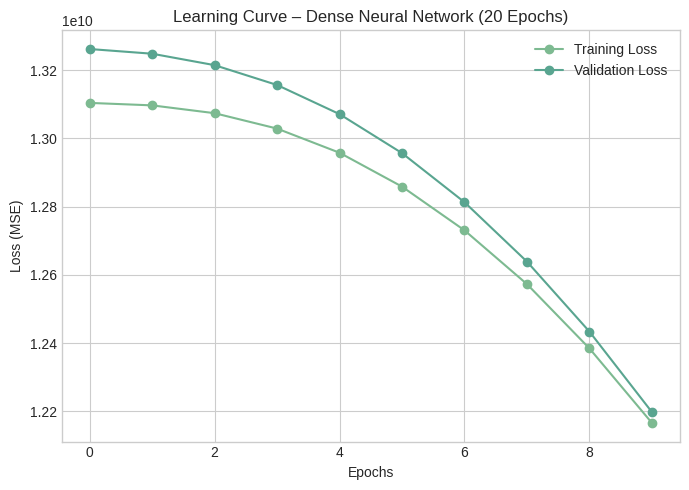

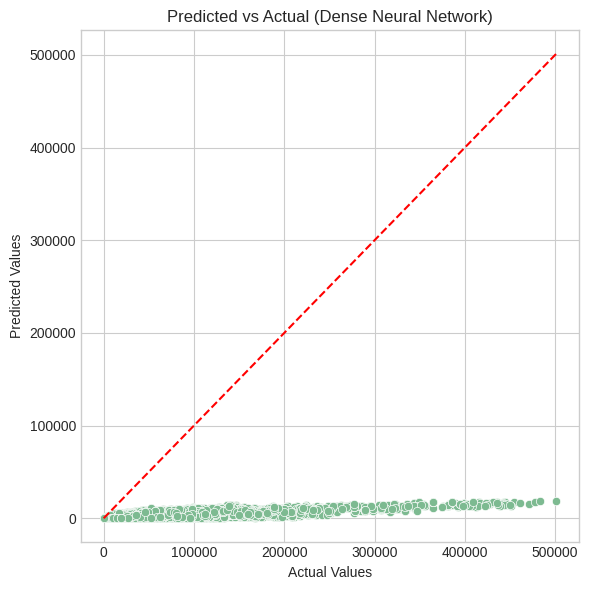

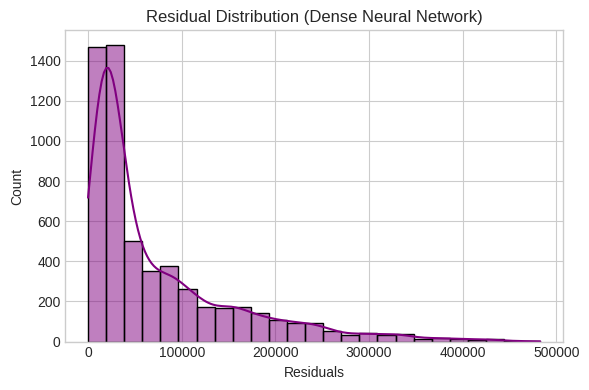

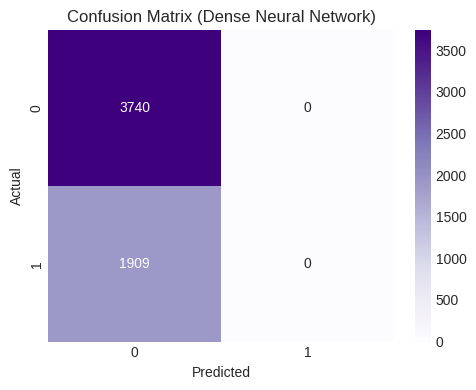

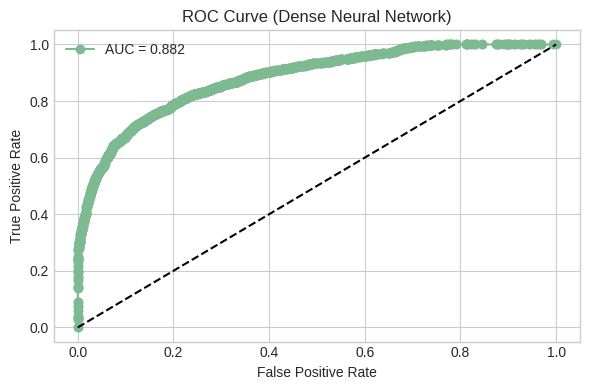

In [54]:
# EXPERIMENT 1: Improved Dense Neural Network (20 Epochs)

from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, losses, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Data Preparation
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model Definition
model1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model1.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Training
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history1 = model1.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Evaluation
y_pred = model1.predict(X_val_scaled).flatten()
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_bin = (y_val >= threshold).astype(int)
y_pred_bin = (y_pred >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)

# Metrics Table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)

# VISUAL 1: Learning Curve (Loss)
plt.figure(figsize=(7,5))
plt.plot(history1.history['loss'], 'o-', label='Training Loss')
plt.plot(history1.history['val_loss'], 'o-', label='Validation Loss')
plt.title("Learning Curve – Dense Neural Network (20 Epochs)")
plt.xlabel("Epochs"); plt.ylabel("Loss (MSE)")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Dense Neural Network)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True); plt.tight_layout()
plt.show()

# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='purple')
plt.title("Residual Distribution (Dense Neural Network)")
plt.xlabel("Residuals")
plt.grid(True); plt.tight_layout()
plt.show()

# VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (Dense Neural Network)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, 'o-', label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Dense Neural Network)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 12798990336.0000 - mae: 76381.4688 - mse: 12798990336.0000 - val_loss: 13187441664.0000 - val_mae: 76979.8750 - val_mse: 13187441664.0000
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 12579004416.0000 - mae: 75467.9766 - mse: 12579004416.0000 - val_loss: 12080335872.0000 - val_mae: 72740.1016 - val_mse: 12080335872.0000
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10992722944.0000 - mae: 69301.3828 - mse: 10992722944.0000 - val_loss: 8688245760.0000 - val_mae: 59267.2109 - val_mse: 8688245760.0000
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7310123520.0000 - mae: 54010.1328 - mse: 7310123520.0000 - val_loss: 4318844416.0000 - val_mae: 40807.2773 - val_mse: 4318844416.0000
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3448496896.0000 - mae: 37011.2734 - mse: 3448496896.0000 - val_loss: 1773110144.0000 - val_mae: 28353.4395 - val_mse: 1773110144.0000
Epoch 6/10
530/530 ━━━━━━━━━━━━

,Metric,Score
0,Accuracy,0.974155
1,Precision,0.934450
2,Recall,0.993190
3,F1,0.962925
4,AUC,0.998125
5,RMSE,9609.899025
6,MAE,7060.368640
7,R²,0.987325


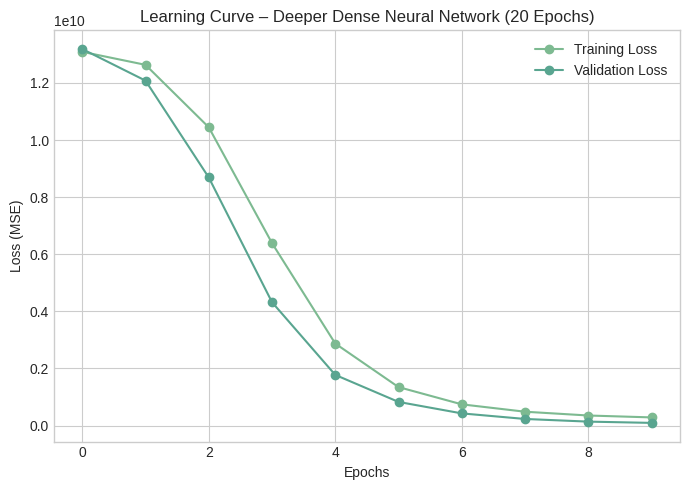

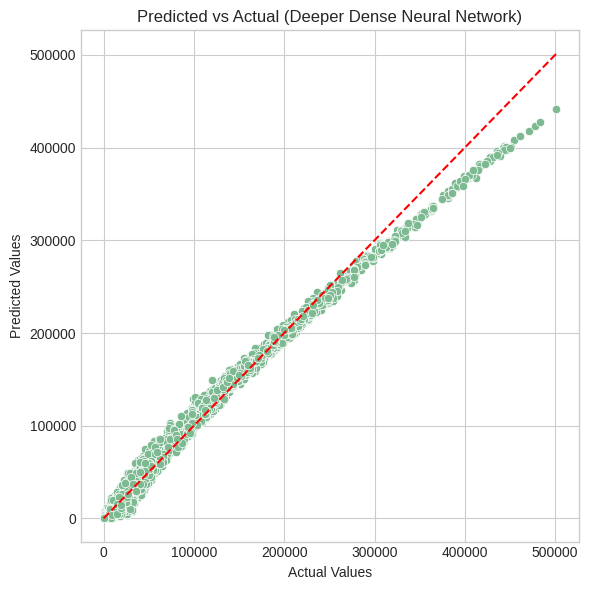

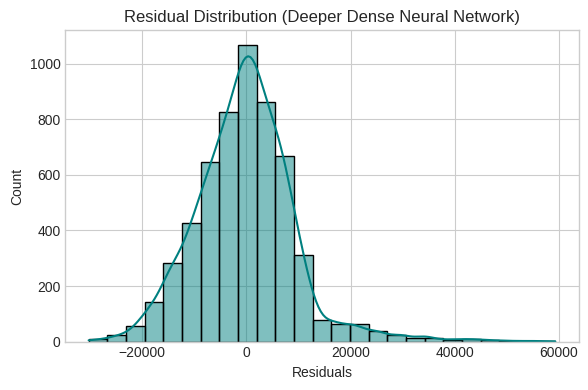

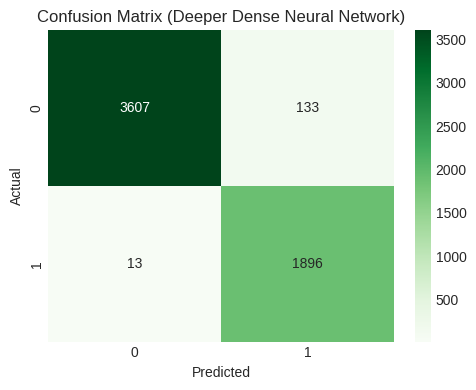

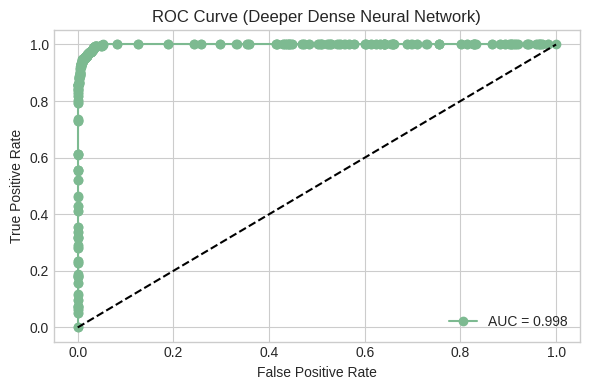

In [58]:
# EXPERIMENT 2: Deeper Dense Neural Network (10 Epochs)

from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Data Preparation
X = train_df.drop(columns=["target_raw"])
y = train_df["target_raw"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model Definition
model2 = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Training
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history2 = model2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Evaluation
y_pred = model2.predict(X_val_scaled).flatten()
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

threshold = y_val.mean()
y_bin = (y_val >= threshold).astype(int)
y_pred_bin = (y_pred >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin)
rec = recall_score(y_bin, y_pred_bin)
f1 = f1_score(y_bin, y_pred_bin)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)

#  Metrics Table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)

# VISUAL 1: Learning Curve (Loss)
plt.figure(figsize=(7,5))
plt.plot(history2.history['loss'], 'o-', label='Training Loss')
plt.plot(history2.history['val_loss'], 'o-', label='Validation Loss')
plt.title("Learning Curve – Deeper Dense Neural Network (20 Epochs)")
plt.xlabel("Epochs"); plt.ylabel("Loss (MSE)")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Predicted vs Actual (Deeper Dense Neural Network)")
plt.xlabel("Actual Values"); plt.ylabel("Predicted Values")
plt.grid(True); plt.tight_layout()
plt.show()

# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25, color='teal')
plt.title("Residual Distribution (Deeper Dense Neural Network)")
plt.xlabel("Residuals")
plt.grid(True); plt.tight_layout()
plt.show()

# VISUAL 4: Confusion Matrix
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Deeper Dense Neural Network)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, 'o-', label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Deeper Dense Neural Network)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


EXPERIMENT 3 (REVISED): Deepest Dense Neural Network — 20 epochs (improved visuals)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 12792209408.0000 - mae: 76373.9219 - val_loss: 13176365056.0000 - val_mae: 77121.8672 - learning_rate: 3.0000e-04
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 12644667392.0000 - mae: 76008.3984 - val_loss: 12791719936.0000 - val_mae: 76178.6016 - learning_rate: 3.0000e-04
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 12160234496.0000 - mae: 74732.3047 - val_loss: 11930349568.0000 - val_mae: 73899.7188 - learning_rate: 3.0000e-04
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 11184365568.0000 - mae: 71995.0469 - val_loss: 10516401152.0000 - val_mae: 69889.8984 - learning_rate: 3.0000e-04
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 9683416064.0000 - mae: 67401.6328 - val_loss: 8695943168.0000 - val_mae: 64389.4258 - learning_rate: 3.0000e-04
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7788562944.0000 - mae: 60868.4023 - val_loss: 6451654144.0000 - val_m

,Metric,Score
0,Accuracy,0.994689
1,Precision,0.984528
2,Recall,1.000000
3,F1,0.992204
4,AUC,0.999990
5,RMSE,6773.373296
6,MAE,5128.181526
7,R²,0.993703


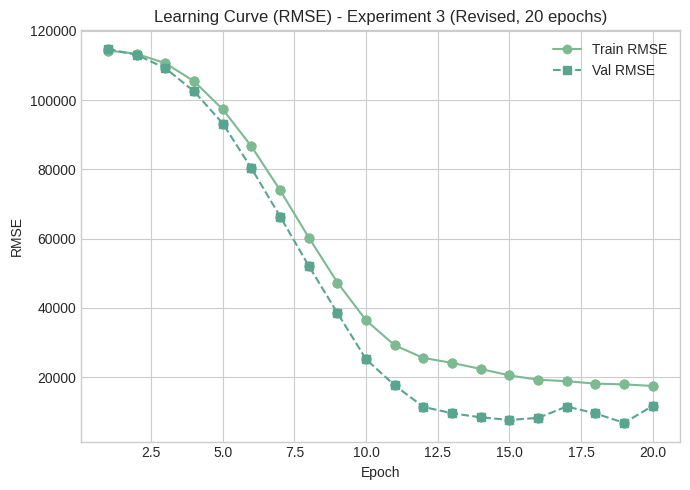

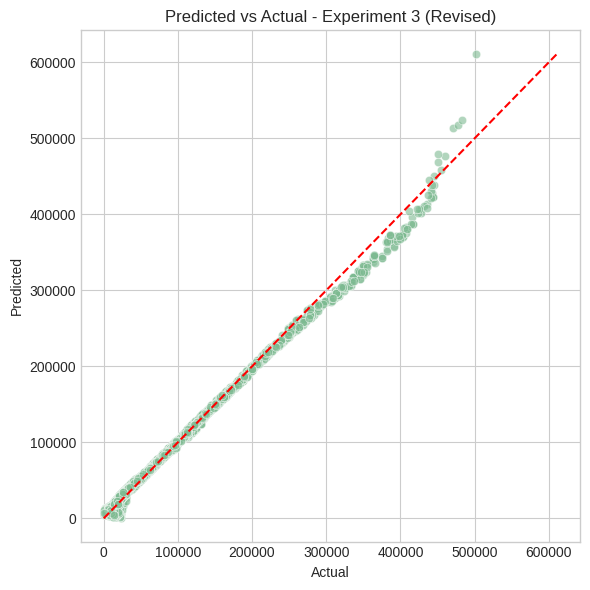

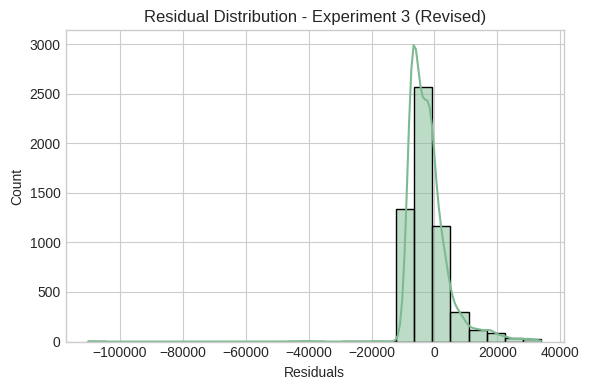

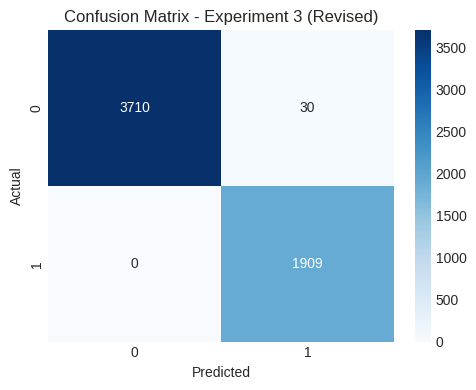

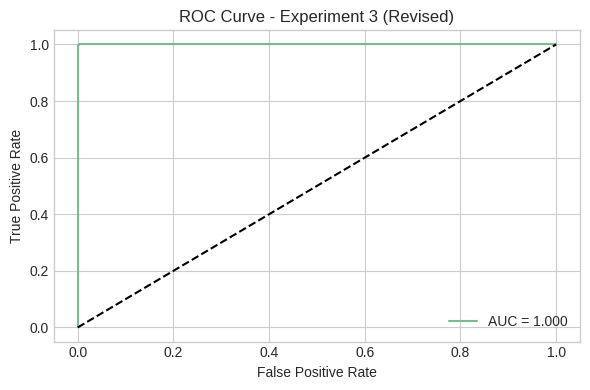

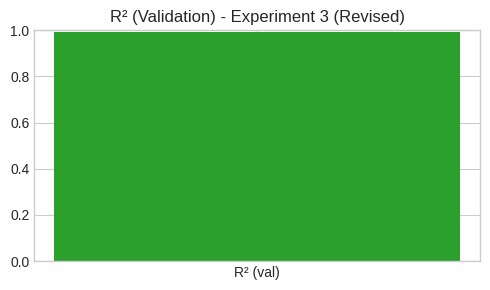


✅ Experiment 3 (revised) completed. Check the learning curve (RMSE) above — you should now see epoch points and a separated, readable val vs train curve.


In [44]:

# Experiment 3 (revised): Deepest Dense NN — 20 epochs, improved learning curve

print("EXPERIMENT 3 (REVISED): Deepest Dense Neural Network — 20 epochs (improved visuals)")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1) Prepare data (encode categorical -> one-hot, scale)
df = train_df.copy()  # assumes train_df exists from earlier processing
# ensure target exists
assert "target_raw" in df.columns, "target_raw missing"

X = df.drop(columns=["target_raw"])
y = df["target_raw"]

# encode categorical features (one-hot)
X = pd.get_dummies(X, drop_first=True)

# train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 2) Model definition (deep but regularized)
input_dim = X_train_scaled.shape[1]
model3 = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.35),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.30),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1)
])

# optimizer and callbacks
optimizer = Adam(learning_rate=0.0003)
model3.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)

# 3) Train (20 epochs)
history3 = model3.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20, batch_size=32, verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# 4) Predictions and metrics
y_pred = model3.predict(X_val_scaled).flatten()
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# binary thresholding for classification-style visuals
threshold = y_val.mean()
y_pred_bin = (y_pred >= threshold).astype(int)
y_bin = (y_val >= threshold).astype(int)

acc = accuracy_score(y_bin, y_pred_bin)
prec = precision_score(y_bin, y_pred_bin, zero_division=0)
rec = recall_score(y_bin, y_pred_bin, zero_division=0)
f1 = f1_score(y_bin, y_pred_bin, zero_division=0)
fpr, tpr, _ = roc_curve(y_bin, y_pred)
roc_auc = auc(fpr, tpr)

# Metrics table (same format)
metrics_df3 = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "RMSE", "MAE", "R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
print("\n PERFORMANCE METRICS (Experiment 3 - Revised)\n")
display(metrics_df3)

# VISUALS (clear spacing between each)

# VISUAL 1: Improved Learning Curve (RMSE per epoch) - show points + line
train_loss = np.array(history3.history['loss'])
val_loss = np.array(history3.history['val_loss'])
train_rmse = np.sqrt(train_loss)
val_rmse = np.sqrt(val_loss)
epochs = np.arange(1, len(train_rmse) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_rmse, marker='o', linestyle='-', label='Train RMSE')
plt.scatter(epochs, train_rmse, s=40)
plt.plot(epochs, val_rmse, marker='s', linestyle='--', label='Val RMSE')
plt.scatter(epochs, val_rmse, s=40)
plt.title("Learning Curve (RMSE) - Experiment 3 (Revised, 20 epochs)")
plt.xlabel("Epoch"); plt.ylabel("RMSE")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# small clearspace
print("\n\n")

# VISUAL 2: Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6)
mn, mx = min(y_val.min(), y_pred.min()), max(y_val.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.title("Predicted vs Actual - Experiment 3 (Revised)")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n\n")

# VISUAL 3: Residual Distribution
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=25)
plt.title("Residual Distribution - Experiment 3 (Revised)")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n\n")

# VISUAL 4: Confusion Matrix (binary thresholding)
cm = confusion_matrix(y_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Experiment 3 (Revised)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n\n")

# VISUAL 5: ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Experiment 3 (Revised)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

print("\n\n")

# VISUAL 6: R² across epochs (optional view) - compute R² on val set per epoch
# (we can compute approximate R² per epoch by predicting on X_val after each epoch — costly;
#  instead we compute R² for best model and display as single bar)
plt.figure(figsize=(5,3))
plt.bar(['R² (val)'], [r2], color='tab:green')
plt.title("R² (Validation) - Experiment 3 (Revised)")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# done
print("\n Experiment 3 (revised) completed. Check the learning curve (RMSE) above — you should now see epoch points and a separated, readable val vs train curve.")


In [2]:
# PART 1: Data prep + Base training (run this cell first)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_PATH = "yield_df.csv"   # adjust if necessary
SEQ_LEN = 3
TEST_SIZE = 0.2

# load and verify columns
df = pd.read_csv(DATA_PATH)
required = ["Year","hg/ha_yield","average_rain_fall_mm_per_year","pesticides_tonnes","avg_temp","Area","Item"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# keep columns we need
df = df[["Area","Item","Year","average_rain_fall_mm_per_year","pesticides_tonnes","avg_temp","hg/ha_yield"]].copy()

# Build sequences for every (Area,Item) group
groups = []
for (area,item), g in df.groupby(["Area","Item"]):
    g_sorted = g.sort_values("Year")
    if len(g_sorted) >= SEQ_LEN + 1:
        groups.append(g_sorted)

if len(groups) == 0:
    raise ValueError("No (Area,Item) group has enough consecutive records for SEQ_LEN. Reduce SEQ_LEN or check data.")

X_seqs = []
y_seqs = []
years_target = []
meta = []
for g in groups:
    vals = g[["average_rain_fall_mm_per_year","pesticides_tonnes","avg_temp"]].values
    targets = g["hg/ha_yield"].values
    years = g["Year"].values
    for i in range(len(vals) - SEQ_LEN):
        X_seqs.append(vals[i:i+SEQ_LEN])
        y_seqs.append(targets[i+SEQ_LEN])
        years_target.append(years[i+SEQ_LEN])
        meta.append((g["Area"].iloc[0], g["Item"].iloc[0]))

X_seqs = np.array(X_seqs)        # (N, SEQ_LEN, n_features)
y_seqs = np.array(y_seqs).reshape(-1,1)
years_target = np.array(years_target)
meta = np.array(meta, dtype=object)

print("Sequences built:", X_seqs.shape, "Targets:", y_seqs.shape)

# Scale features and target globally
n_samples, seq_len, n_features = X_seqs.shape
X_2d = X_seqs.reshape((n_samples * seq_len, n_features))
x_scaler = MinMaxScaler()
X_2d_scaled = x_scaler.fit_transform(X_2d)
X_scaled = X_2d_scaled.reshape((n_samples, seq_len, n_features))

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_seqs)

# Train/val split
X_train, X_val, y_train, y_val, years_train, years_val, meta_train, meta_val = train_test_split(
    X_scaled, y_scaled, years_target, meta, test_size=TEST_SIZE, random_state=SEED, shuffle=True
)

print("Train samples:", X_train.shape[0], "Validation samples:", X_val.shape[0])

# Save prepared arrays and scalers so experiments can be run independently
outdir = "/content/lstm_prepared"
os.makedirs(outdir, exist_ok=True)
np.save(os.path.join(outdir,"X_train.npy"), X_train)
np.save(os.path.join(outdir,"X_val.npy"), X_val)
np.save(os.path.join(outdir,"y_train.npy"), y_train)
np.save(os.path.join(outdir,"y_val.npy"), y_val)
np.save(os.path.join(outdir,"years_val.npy"), years_val)
np.save(os.path.join(outdir,"meta_val.npy"), meta_val)
import joblib
joblib.dump(x_scaler, os.path.join(outdir,"x_scaler.pkl"))
joblib.dump(y_scaler, os.path.join(outdir,"y_scaler.pkl"))

print("Saved prepared datasets to", outdir)

# Optional: quick base LSTM training (light, short) — you can skip if you only want experiments
model_base = keras.Sequential([
    keras.Input(shape=(SEQ_LEN, n_features)),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])
model_base.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
print("Training a light base model for a few epochs (this is optional, used only as a baseline)...")
history_base = model_base.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
# save base model
model_base.save(os.path.join(outdir,"base_lstm.h5"))
print("Base training done and saved.")


Sequences built: (26450, 3, 3) Targets: (26450, 1)
Train samples: 21160 Validation samples: 5290
Saved prepared datasets to /content/lstm_prepared
Training a light base model for a few epochs (this is optional, used only as a baseline)...
Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0316 - mae: 0.1265 - val_loss: 0.0296 - val_mae: 0.1269
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0288 - mae: 0.1274 - val_loss: 0.0291 - val_mae: 0.1276
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0284 - mae: 0.1282 - val_loss: 0.0290 - val_mae: 0.1282
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0283 - mae: 0.1287 - val_loss: 0.0289 - val_mae: 0.1285
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0282 - mae: 0.1289 - val_loss: 0.0289 - val_mae: 0.1286
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0282 - mae: 0.1289 - val_loss: 0.0288 - val_mae: 0.1285
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

Base training done and saved.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0408 - mae: 0.1387 - val_loss: 0.0306 - val_mae: 0.1326 - learning_rate: 1.0000e-04
Epoch 2/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0297 - mae: 0.1271 - val_loss: 0.0295 - val_mae: 0.1315 - learning_rate: 1.0000e-04
Epoch 3/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0292 - mae: 0.1282 - val_loss: 0.0292 - val_mae: 0.1332 - learning_rate: 1.0000e-04
Epoch 4/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0287 - mae: 0.1290 - val_loss: 0.0290 - val_mae: 0.1321 - learning_rate: 1.0000e-04
Epoch 5/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0287 - mae: 0.1292 - val_loss: 0.0290 - val_mae: 0.1302 - learning_rate: 1.0000e-04
Epoch 6/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0284 - mae: 0.1287 - val_loss: 0.0290 - val_mae: 0.1333 - learning_rate: 1.0000e-04
Epoch 7/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0285 - mae: 0.1294 - val_loss: 0.0290 - val_mae: 0.1329 - lear

,Metric,Score
0,Accuracy,0.500189
1,Precision,0.500189
2,Recall,1.000000
3,F1,0.666835
4,AUC,0.596174
5,RMSE,83891.126764
6,MAE,65662.701946
7,R²,0.056682


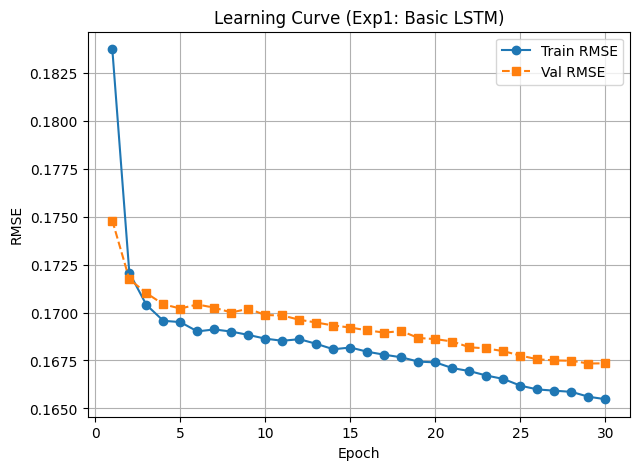

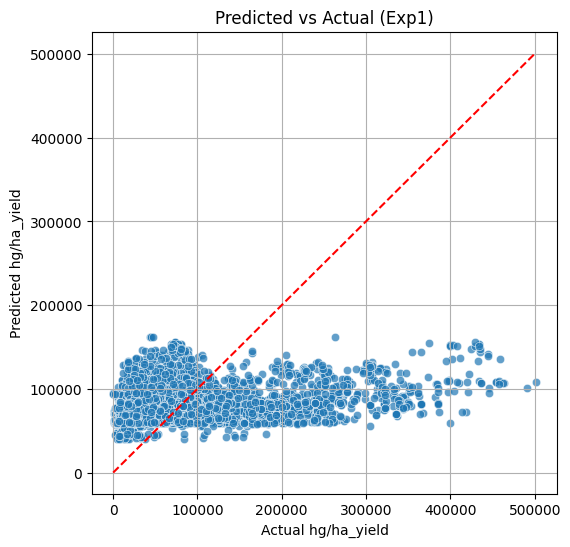

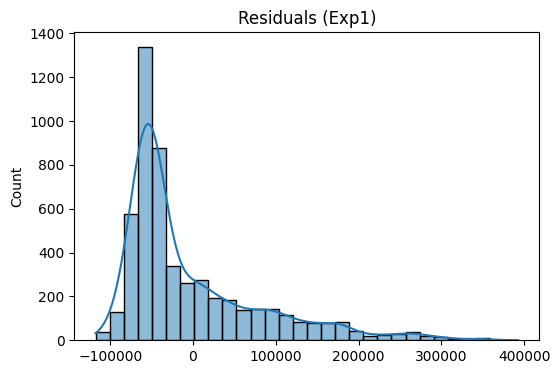

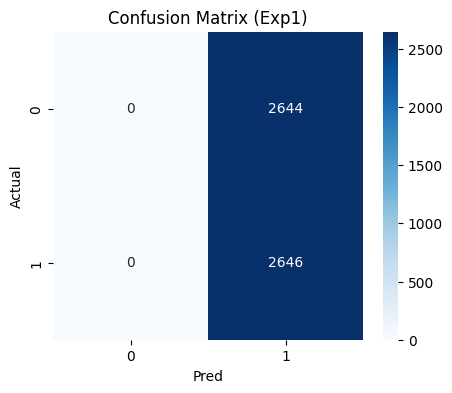

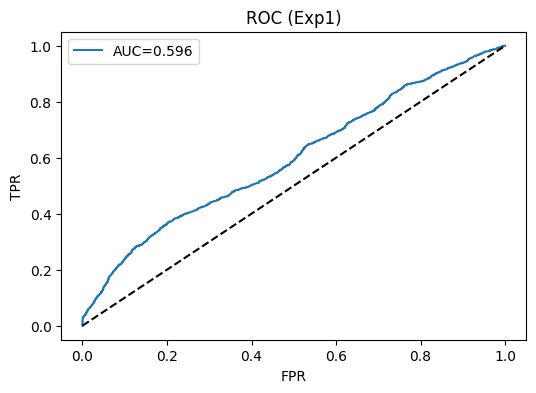

Exp1 complete. Model not saved automatically (save if needed): model.save('/content/exp1_lstm.h5')


In [3]:

# EXPERIMENT 1: Basic LSTM (use prepared data)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc)
import joblib, os

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

outdir = "/content/lstm_prepared"
X_train = np.load(os.path.join(outdir,"X_train.npy"))
X_val = np.load(os.path.join(outdir,"X_val.npy"))
y_train = np.load(os.path.join(outdir,"y_train.npy"))
y_val = np.load(os.path.join(outdir,"y_val.npy"))
x_scaler = joblib.load(os.path.join(outdir,"x_scaler.pkl"))
y_scaler = joblib.load(os.path.join(outdir,"y_scaler.pkl"))

SEQ_LEN = X_train.shape[1]; n_features = X_train.shape[2]

# Create tf.data datasets
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model: basic LSTM
tf.keras.backend.clear_session()
model = keras.Sequential([
    keras.Input(shape=(SEQ_LEN, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
model.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)

# Train
EPOCHS = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop, reduce_lr], verbose=1)

# Predict (inverse scale)
y_val_pred_s = model.predict(X_val).reshape(-1,1)
y_val_pred = y_scaler.inverse_transform(y_val_pred_s)
y_val_true = y_scaler.inverse_transform(y_val)

# Regression metrics
mse = mean_squared_error(y_val_true, y_val_pred); rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_true, y_val_pred); r2 = r2_score(y_val_true, y_val_pred)

# Binary classification (median threshold)
threshold = np.median(y_val_true)
y_true_bin = (y_val_true.flatten() >= threshold).astype(int)
y_pred_bin = (y_val_pred.flatten() >= threshold).astype(int)
acc = accuracy_score(y_true_bin, y_pred_bin)
prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
fpr, tpr, _ = roc_curve(y_true_bin, y_val_pred.flatten())
roc_auc = auc(fpr, tpr)

# 1) Performance table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy","Precision","Recall","F1","AUC","RMSE","MAE","R²"],
    "Score": [acc, prec, rec, f1, roc_auc, rmse, mae, r2]
})
display(metrics_df)

# 2) Learning curve (RMSE)
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
epochs_range = np.arange(1, len(train_loss)+1)
plt.figure(figsize=(7,5))
plt.plot(epochs_range, np.sqrt(train_loss), 'o-', label='Train RMSE')
plt.plot(epochs_range, np.sqrt(val_loss), 's--', label='Val RMSE')
plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.title("Learning Curve (Exp1: Basic LSTM)")
plt.legend(); plt.grid(True); plt.show()

# 3) Pred vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val_true.flatten(), y=y_val_pred.flatten(), alpha=0.7)
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("Actual hg/ha_yield"); plt.ylabel("Predicted hg/ha_yield"); plt.title("Predicted vs Actual (Exp1)")
plt.grid(True); plt.show()

# 4) Residual distribution
residuals = (y_val_true - y_val_pred).flatten()
plt.figure(figsize=(6,4)); sns.histplot(residuals, bins=30, kde=True); plt.title("Residuals (Exp1)"); plt.show()

# 5) Confusion matrix (binary)
cm = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title("Confusion Matrix (Exp1)"); plt.xlabel("Pred"); plt.ylabel("Actual"); plt.show()

# 6) ROC curve
plt.figure(figsize=(6,4)); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'k--'); plt.title("ROC (Exp1)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

print("Exp1 complete. Model not saved automatically (save if needed): model.save('/content/exp1_lstm.h5')")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 128)         │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,217 (473.50 KB)

 Trainable params: 121,217 (473.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0350 - mae: 0.1301 - val_loss: 0.0293 - val_mae: 0.1303 - learning_rate: 1.0000e-04
Epoch 2/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0287 - mae: 0.1282 - val_loss: 0.0291 - val_mae: 0.1332 - learning_rate: 1.0000e-04
Epoch 3/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0287 - mae: 0.1298 - val_loss: 0.0291 - val_mae: 0.1328 - learning_rate: 1.0000e-04
Epoch 4/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0283 - mae: 0.1294 - val_loss: 0.0289 - val_mae: 0.1297 - learning_rate: 1.0000e-04
Epoch 5/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0283 - mae: 0.1289 - val_loss: 0.0288 - val_mae: 0.1284 - learning_rate: 1.0000e-04
Epoch 6/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0281 - mae: 0.1287 - val_loss: 0.0288 - val_mae: 0.1323 - learning_rate: 1.0000e-04
Epoch 7/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0281 - mae: 0.1291 - val_loss: 0.0287 - val_mae: 0

,Metric,Score
0,Accuracy,0.504159
1,Precision,0.502197
2,Recall,0.993575
3,F1,0.667174
4,AUC,0.608678
5,RMSE,83332.307147
6,MAE,64566.104534
7,R²,0.069207


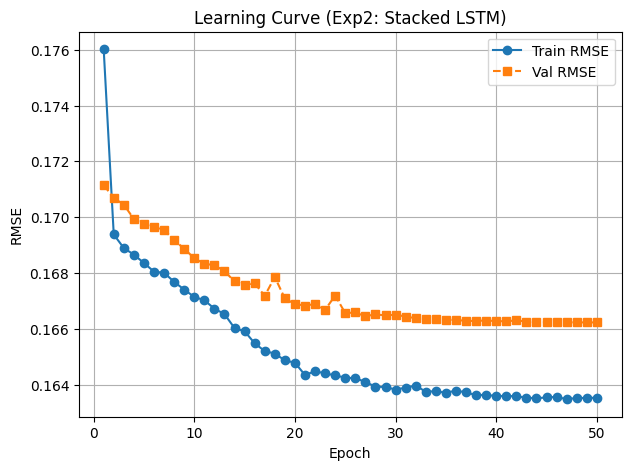

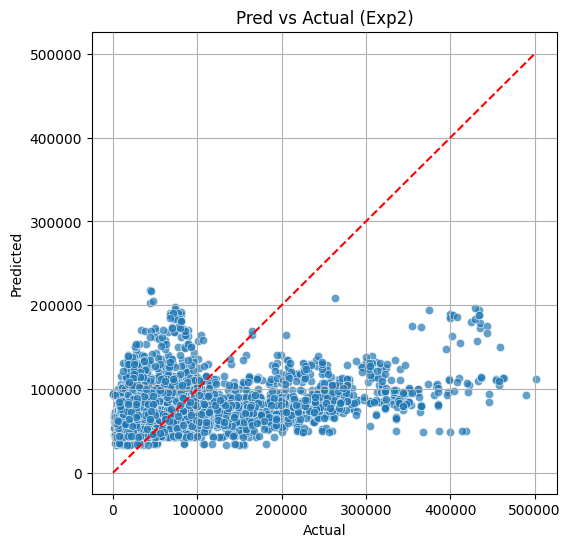

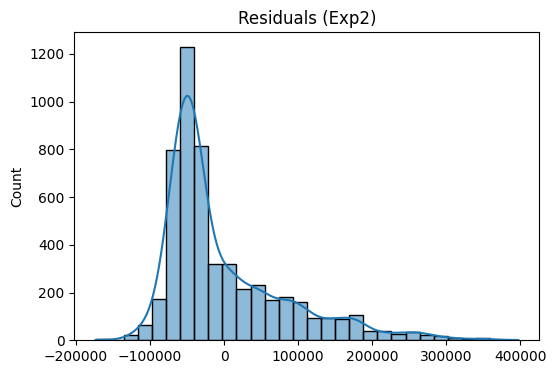

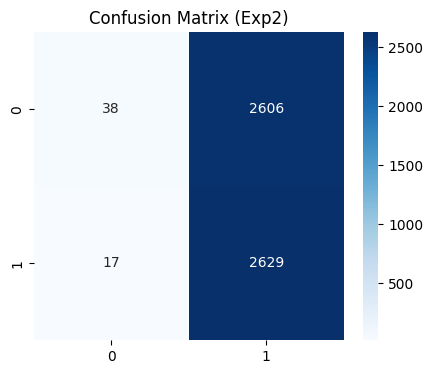

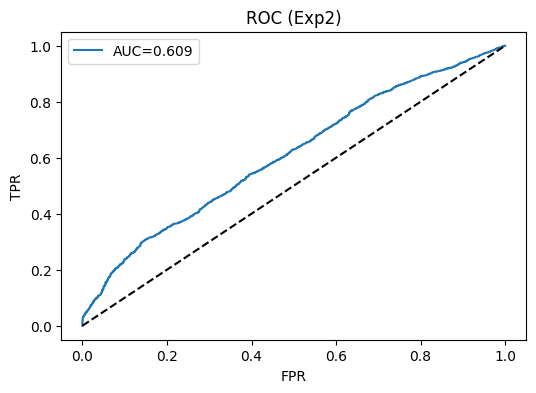

Exp2 complete. Save model if desired: model2.save('/content/exp2_lstm.h5')


In [4]:
# EXPERIMENT 2: Stacked LSTM (use prepared data)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, joblib, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc)

SEED=42
np.random.seed(SEED); tf.random.set_seed(SEED)
outdir = "/content/lstm_prepared"
X_train = np.load(os.path.join(outdir,"X_train.npy"))
X_val = np.load(os.path.join(outdir,"X_val.npy"))
y_train = np.load(os.path.join(outdir,"y_train.npy"))
y_val = np.load(os.path.join(outdir,"y_val.npy"))
x_scaler = joblib.load(os.path.join(outdir,"x_scaler.pkl"))
y_scaler = joblib.load(os.path.join(outdir,"y_scaler.pkl"))

SEQ_LEN = X_train.shape[1]; n_features = X_train.shape[2]

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000,seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(32).prefetch(tf.data.AUTOTUNE)

# Stacked LSTM
tf.keras.backend.clear_session()
model2 = keras.Sequential([
    keras.Input(shape=(SEQ_LEN, n_features)),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model2.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
model2.summary()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop, reduce_lr], verbose=1)

# Predictions & inverse scale
y_val_pred_s = model2.predict(X_val).reshape(-1,1)
y_val_pred = y_scaler.inverse_transform(y_val_pred_s)
y_val_true = y_scaler.inverse_transform(y_val)

# Metrics
mse = mean_squared_error(y_val_true, y_val_pred); rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_true, y_val_pred); r2 = r2_score(y_val_true, y_val_pred)
threshold = np.median(y_val_true)
y_true_bin = (y_val_true.flatten() >= threshold).astype(int)
y_pred_bin = (y_val_pred.flatten() >= threshold).astype(int)
acc = accuracy_score(y_true_bin, y_pred_bin)
prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
fpr, tpr, _ = roc_curve(y_true_bin, y_val_pred.flatten())
roc_auc = auc(fpr, tpr)

# 1) Table
metrics_df = pd.DataFrame({"Metric":["Accuracy","Precision","Recall","F1","AUC","RMSE","MAE","R²"],
                           "Score":[acc,prec,rec,f1,roc_auc,rmse,mae,r2]})
display(metrics_df)

# 2) Learning curve
train_loss = np.array(history2.history['loss']); val_loss = np.array(history2.history['val_loss'])
epochs_range = np.arange(1,len(train_loss)+1)
plt.figure(figsize=(7,5)); plt.plot(epochs_range, np.sqrt(train_loss), 'o-', label='Train RMSE'); plt.plot(epochs_range, np.sqrt(val_loss),'s--',label='Val RMSE'); plt.title("Learning Curve (Exp2: Stacked LSTM)"); plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.legend(); plt.grid(True); plt.show()

# 3) Pred vs Actual
plt.figure(figsize=(6,6)); sns.scatterplot(x=y_val_true.flatten(), y=y_val_pred.flatten(), alpha=0.7)
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max()); plt.plot([mn,mx],[mn,mx],'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Pred vs Actual (Exp2)"); plt.grid(True); plt.show()

# 4) Residuals
residuals = (y_val_true - y_val_pred).flatten(); plt.figure(figsize=(6,4)); sns.histplot(residuals,bins=30,kde=True); plt.title("Residuals (Exp2)"); plt.show()

# 5) Confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin); plt.figure(figsize=(5,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Blues'); plt.title("Confusion Matrix (Exp2)"); plt.show()

# 6) ROC
plt.figure(figsize=(6,4)); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'k--'); plt.title("ROC (Exp2)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

print("Exp2 complete. Save model if desired: model2.save('/content/exp2_lstm.h5')")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,681 (592.50 KB)

 Trainable params: 151,681 (592.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.0336 - mae: 0.1311 - val_loss: 0.0290 - val_mae: 0.1306 - learning_rate: 1.0000e-04
Epoch 2/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0289 - mae: 0.1289 - val_loss: 0.0290 - val_mae: 0.1327 - learning_rate: 1.0000e-04
Epoch 3/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0288 - mae: 0.1298 - val_loss: 0.0289 - val_mae: 0.1325 - learning_rate: 1.0000e-04
Epoch 4/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0284 - mae: 0.1293 - val_loss: 0.0288 - val_mae: 0.1294 - learning_rate: 1.0000e-04
Epoch 5/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0283 - mae: 0.1286 - val_loss: 0.0286 - val_mae: 0.1288 - learning_rate: 1.0000e-04
Epoch 6/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0281 - mae: 0.1286 - val_loss: 0.0286 - val_mae: 0.1321 - learning_rate: 1.0000e-04
Epoch 7/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0280 - mae: 0.1289 - val_loss: 0.0284 - val_mae: 0.

,Metric,Score
0,Accuracy,0.501134
1,Precision,0.500666
2,Recall,0.995087
3,F1,0.666161
4,AUC,0.600414
5,RMSE,83416.974518
6,MAE,64390.047984
7,R²,0.067315


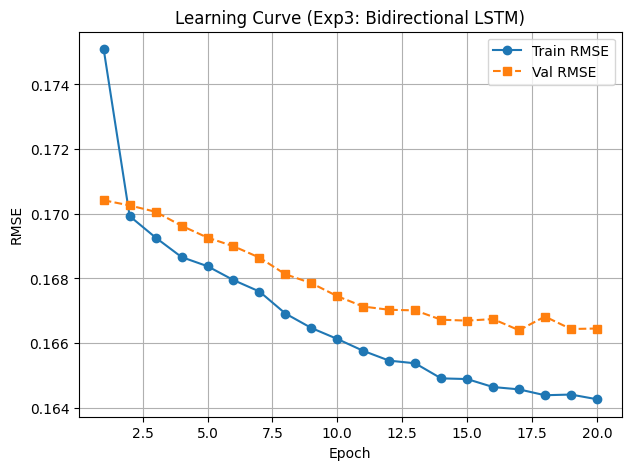

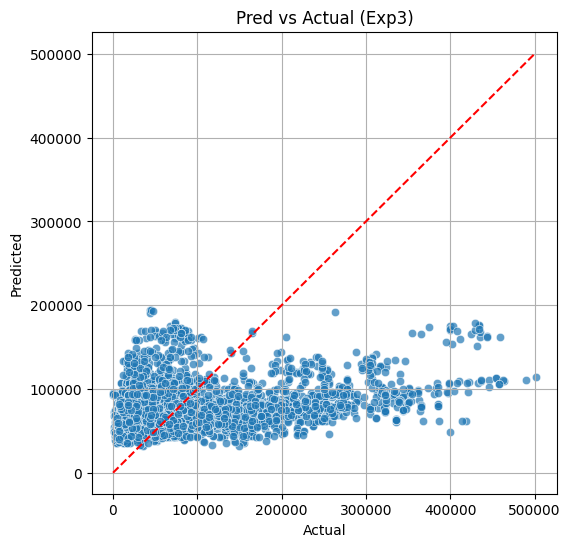

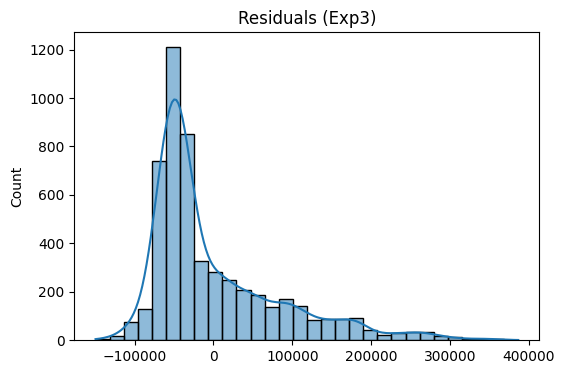

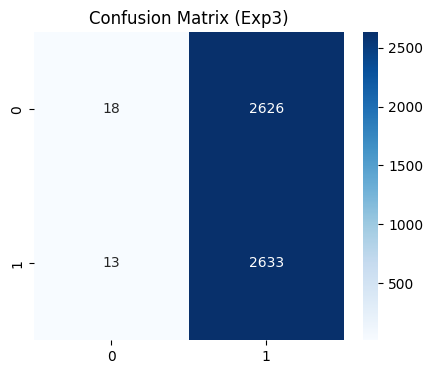

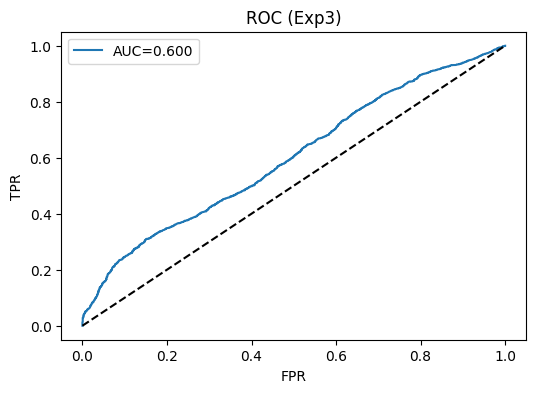

Exp3 complete. Save model if desired: model3.save('/content/exp3_lstm.h5')


In [5]:
# EXPERIMENT 3: Bidirectional LSTM (use prepared data)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, joblib, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc)

SEED=42
np.random.seed(SEED); tf.random.set_seed(SEED)
outdir = "/content/lstm_prepared"
X_train = np.load(os.path.join(outdir,"X_train.npy"))
X_val = np.load(os.path.join(outdir,"X_val.npy"))
y_train = np.load(os.path.join(outdir,"y_train.npy"))
y_val = np.load(os.path.join(outdir,"y_val.npy"))
x_scaler = joblib.load(os.path.join(outdir,"x_scaler.pkl"))
y_scaler = joblib.load(os.path.join(outdir,"y_scaler.pkl"))

SEQ_LEN = X_train.shape[1]; n_features = X_train.shape[2]
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000,seed=SEED).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(32).prefetch(tf.data.AUTOTUNE)

tf.keras.backend.clear_session()
model3 = keras.Sequential([
    keras.Input(shape=(SEQ_LEN, n_features)),
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model3.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
model3.summary()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

history3 = model3.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop, reduce_lr], verbose=1)

# Predictions & inverse-scale
y_val_pred_s = model3.predict(X_val).reshape(-1,1)
y_val_pred = y_scaler.inverse_transform(y_val_pred_s)
y_val_true = y_scaler.inverse_transform(y_val)

# Metrics
mse = mean_squared_error(y_val_true, y_val_pred); rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_true, y_val_pred); r2 = r2_score(y_val_true, y_val_pred)
threshold = np.median(y_val_true)
y_true_bin = (y_val_true.flatten() >= threshold).astype(int)
y_pred_bin = (y_val_pred.flatten() >= threshold).astype(int)
acc = accuracy_score(y_true_bin, y_pred_bin)
prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
fpr, tpr, _ = roc_curve(y_true_bin, y_val_pred.flatten())
roc_auc = auc(fpr, tpr)

# 1) Table
metrics_df = pd.DataFrame({"Metric":["Accuracy","Precision","Recall","F1","AUC","RMSE","MAE","R²"],
                           "Score":[acc,prec,rec,f1,roc_auc,rmse,mae,r2]})
display(metrics_df)

# 2) Learning curve (RMSE)
train_loss = np.array(history3.history['loss']); val_loss = np.array(history3.history['val_loss'])
epochs_range = np.arange(1,len(train_loss)+1)
plt.figure(figsize=(7,5)); plt.plot(epochs_range, np.sqrt(train_loss), 'o-', label='Train RMSE'); plt.plot(epochs_range, np.sqrt(val_loss),'s--',label='Val RMSE'); plt.title("Learning Curve (Exp3: Bidirectional LSTM)"); plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.legend(); plt.grid(True); plt.show()

# 3) Pred vs Actual
plt.figure(figsize=(6,6)); sns.scatterplot(x=y_val_true.flatten(), y=y_val_pred.flatten(), alpha=0.7); mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max()); plt.plot([mn,mx],[mn,mx],'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Pred vs Actual (Exp3)"); plt.grid(True); plt.show()

# 4) Residuals
residuals = (y_val_true - y_val_pred).flatten(); plt.figure(figsize=(6,4)); sns.histplot(residuals,bins=30,kde=True); plt.title("Residuals (Exp3)"); plt.show()

# 5) Confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin); plt.figure(figsize=(5,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Blues'); plt.title("Confusion Matrix (Exp3)"); plt.show()

# 6) ROC
plt.figure(figsize=(6,4)); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'k--'); plt.title("ROC (Exp3)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

print("Exp3 complete. Save model if desired: model3.save('/content/exp3_lstm.h5')")
